# Set up

### Libraries

In [145]:
import pandas as pd
import numpy as np
import seaborn as sns
import scikitplot as skplt
import math
import lightgbm as lgbm

from dython import nominal
from sklearn                 import model_selection  as ms
from matplotlib              import pyplot as plt
from sklearn                 import ensemble         as en
from sklearn                 import neighbors        as nh
from sklearn                 import linear_model     as lm
from sklearn.metrics import cohen_kappa_score, ndcg_score, classification_report
import lightgbm as lgbm
from sklearn.tree import export_graphviz
import graphviz
from IPython.display         import HTML
from skopt                   import BayesSearchCV
from sklearn.compose         import make_column_transformer, ColumnTransformer
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder, OneHotEncoder as pp
from tabulate                import tabulate
from boruta                  import BorutaPy
from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn                 import model_selection, metrics
from xgboost                 import XGBClassifier
from sklearn.metrics         import make_scorer, accuracy_score
from sklearn.inspection      import permutation_importance
from imblearn.pipeline       import Pipeline, make_pipeline
from category_encoders       import TargetEncoder
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.base           import BaseEstimator, TransformerMixin




### Functions

In [80]:


def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [81]:
jupyter_settings()

### Import Data

In [82]:
df_train_raw = pd.read_csv('train.csv', low_memory=False)

## ETL

### Data Raw status

In [83]:
df1 = df_train_raw.copy()

#### Dados

In [84]:
df1.head(5)

,id,Gender,Customer Type,Age,Type of Purchase,Store size,Store distance,InStore wifi,Open/Close time convenient,Easy of online shopping,Store location,Toilet cleaning,Dressing room,Waiting room,Kids entertainment,Seller service,Showroom,Self-Store,Purchase service,Store Service,Cleanliness,Carrier delay in minutes,Delivery delay in minutes,Satisfaction
0,70172,Male,Loyal Customer,13,Personal,Small,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,Neutral or Dissatisfaction
1,5047,Male,disloyal Customer,25,Gift,Large,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,Neutral or Dissatisfaction
2,110028,Female,Loyal Customer,26,Gift,Large,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,Satisfied
3,24026,Female,Loyal Customer,25,Gift,Large,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,Neutral or Dissatisfaction
4,119299,Male,Loyal Customer,61,Gift,Large,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,Satisfied


In [85]:
df1.dtypes

id                              int64
Gender                         object
Customer Type                  object
Age                             int64
Type of Purchase               object
Store size                     object
Store distance                  int64
InStore wifi                    int64
Open/Close time convenient      int64
Easy of online shopping         int64
Store location                  int64
Toilet cleaning                 int64
Dressing room                   int64
Waiting room                    int64
Kids entertainment              int64
Seller service                  int64
Showroom                        int64
Self-Store                      int64
Purchase service                int64
Store Service                   int64
Cleanliness                     int64
Carrier delay in minutes        int64
Delivery delay in minutes     float64
Satisfaction                   object
dtype: object

In [86]:
df1.isna().sum()

id                              0
Gender                          0
Customer Type                   0
Age                             0
Type of Purchase                0
Store size                      0
Store distance                  0
InStore wifi                    0
Open/Close time convenient      0
Easy of online shopping         0
Store location                  0
Toilet cleaning                 0
Dressing room                   0
Waiting room                    0
Kids entertainment              0
Seller service                  0
Showroom                        0
Self-Store                      0
Purchase service                0
Store Service                   0
Cleanliness                     0
Carrier delay in minutes        0
Delivery delay in minutes     310
Satisfaction                    0
dtype: int64

### Rename Columns

In [87]:
df1.columns

Index(['id', 'Gender', 'Customer Type', 'Age', 'Type of Purchase',
       'Store size', 'Store distance', 'InStore wifi',
       'Open/Close time convenient', 'Easy of online shopping',
       'Store location', 'Toilet cleaning', 'Dressing room', 'Waiting room',
       'Kids entertainment', 'Seller service', 'Showroom ', 'Self-Store',
       'Purchase service', 'Store Service', 'Cleanliness',
       'Carrier delay in minutes', 'Delivery delay in minutes',
       'Satisfaction'],
      dtype='object')

In [88]:
old_columns = [ 'id', 'Gender', 'Customer Type', 'Age', 'Type of Purchase',
       'Store size', 'Store distance', 'InStore wifi',
       'Open/Close time convenient', 'Easy of online shopping',
       'Store location', 'Toilet cleaning', 'Dressing room', 'Waiting room',
       'Kids entertainment', 'Seller service', 'Showroom ', 'Self-Store',
       'Purchase service', 'Store Service', 'Cleanliness',
       'Carrier delay in minutes', 'Delivery delay in minutes',
       'Satisfaction' ]


old_columns = pd.Series(old_columns).apply(lambda x: x.strip().replace(' ', '_').lower())

# Rename
df1.columns = old_columns
df1 = df1.rename(columns={'self-store':'self_store'})

df1.columns

Index(['id', 'gender', 'customer_type', 'age', 'type_of_purchase',
       'store_size', 'store_distance', 'instore_wifi',
       'open/close_time_convenient', 'easy_of_online_shopping',
       'store_location', 'toilet_cleaning', 'dressing_room', 'waiting_room',
       'kids_entertainment', 'seller_service', 'showroom', 'self_store',
       'purchase_service', 'store_service', 'cleanliness',
       'carrier_delay_in_minutes', 'delivery_delay_in_minutes',
       'satisfaction'],
      dtype='object')

In [89]:
# Ordinal Encoder - instore_wifi, open/close_time_convenient, easy_of_online_shopping, store_location, toilet_cleaning, 
                    # dressing_room, waiting_room, kids_entertainment, seller_service, showroom, self_store, purchase_service, store_service, cleanliness


# Descriptive Statistical

### Data Dimensions

In [90]:
print(f'Number of Rows {df1.shape[0]}')
print(f'Number of Columns {df1.shape[1]}')

Number of Rows 103904
Number of Columns 24


### Basics Statistics

In [91]:
df2 = df1.copy()

In [92]:
# Split Numerical/Categorical Atributes

num_attributes = df1.select_dtypes( include=['int64', 'float64', 'int32'])
cat_attributes = df1.select_dtypes( include=['object'])

In [93]:
# Cental Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame(num_attributes.apply( np.median )).T


# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( np.min )).T
d3 = pd.DataFrame(num_attributes.apply( np.max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T


# Concatenate
table_m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ]).T.reset_index()
table_m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

table_m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,129880.0,129879.0,64924.210502,64856.5,37463.631970,0.002864,-1.198440
1,age,7.0,85.0,78.0,39.379706,40.0,15.114891,-0.004516,-0.719568
2,store_distance,31.0,4983.0,4952.0,1189.448375,843.0,997.142482,1.109466,0.268535
3,instore_wifi,0.0,5.0,5.0,2.729683,3.0,1.327823,0.040408,-0.846170
4,open/close_time_convenient,0.0,5.0,5.0,3.060296,3.0,1.525068,-0.334399,-1.037767
5,easy_of_online_shopping,0.0,5.0,5.0,2.756901,3.0,1.398923,-0.018294,-0.910346
6,store_location,0.0,5.0,5.0,2.976883,3.0,1.277615,-0.058889,-1.030283
7,toilet_cleaning,0.0,5.0,5.0,3.202129,3.0,1.329526,-0.151279,-1.145453
8,dressing_room,0.0,5.0,5.0,3.250375,3.0,1.349502,-0.453852,-0.702006
9,waiting_room,0.0,5.0,5.0,3.439396,4.0,1.319081,-0.482775,-0.925702


In [94]:
# Outra maneira de fazer a descrição: 
df2.select_dtypes(include=['int64','float64']).describe().T


,count,mean,std,min,25%,50%,75%,max
id,103904.0,64924.210502,37463.812252,1.0,32533.75,64856.5,97368.25,129880.0
age,103904.0,39.379706,15.114964,7.0,27.00,40.0,51.00,85.0
store_distance,103904.0,1189.448375,997.147281,31.0,414.00,843.0,1743.00,4983.0
instore_wifi,103904.0,2.729683,1.327829,0.0,2.00,3.0,4.00,5.0
open/close_time_convenient,103904.0,3.060296,1.525075,0.0,2.00,3.0,4.00,5.0
easy_of_online_shopping,103904.0,2.756901,1.398929,0.0,2.00,3.0,4.00,5.0
store_location,103904.0,2.976883,1.277621,0.0,2.00,3.0,4.00,5.0
toilet_cleaning,103904.0,3.202129,1.329533,0.0,2.00,3.0,4.00,5.0
dressing_room,103904.0,3.250375,1.349509,0.0,2.00,3.0,4.00,5.0
waiting_room,103904.0,3.439396,1.319088,0.0,2.00,4.0,5.00,5.0


### Cat/Num analysis

In [95]:
# Quantos linhas > 0 temos em 'delivery_delay_in_minutes'

df2[df2['delivery_delay_in_minutes'] > 0].select_dtypes(include=['int64','float64']).describe().T

,count,mean,std,min,25%,50%,75%,max
id,45435.0,65318.131286,37976.528318,1.0,32028.0,65225.0,99790.0,129879.0
age,45435.0,39.201497,15.122848,7.0,27.0,39.0,51.0,85.0
store_distance,45435.0,1180.945571,990.756806,31.0,420.0,837.0,1721.0,4983.0
instore_wifi,45435.0,2.680158,1.289738,0.0,2.0,3.0,4.0,5.0
open/close_time_convenient,45435.0,3.055002,1.512327,0.0,2.0,3.0,4.0,5.0
easy_of_online_shopping,45435.0,2.738990,1.380472,0.0,2.0,3.0,4.0,5.0
store_location,45435.0,2.983405,1.273867,1.0,2.0,3.0,4.0,5.0
toilet_cleaning,45435.0,3.160735,1.333214,0.0,2.0,3.0,4.0,5.0
dressing_room,45435.0,3.190074,1.339813,0.0,2.0,3.0,4.0,5.0
waiting_room,45435.0,3.395268,1.322034,0.0,2.0,4.0,4.0,5.0


In [96]:
cat_attributes = df1.select_dtypes( include=['object']).sample(10)
cat_attributes

,gender,customer_type,type_of_purchase,store_size,satisfaction
84707,Female,Loyal Customer,Personal,Medium,Neutral or Dissatisfaction
31383,Female,disloyal Customer,Gift,Large,Satisfied
54395,Female,Loyal Customer,Gift,Large,Satisfied
9243,Female,Loyal Customer,Gift,Large,Satisfied
72043,Female,Loyal Customer,Personal,Medium,Neutral or Dissatisfaction
21677,Male,disloyal Customer,Gift,Large,Satisfied
80672,Female,Loyal Customer,Gift,Large,Neutral or Dissatisfaction
66449,Female,Loyal Customer,Gift,Small,Neutral or Dissatisfaction
24854,Female,disloyal Customer,Gift,Medium,Neutral or Dissatisfaction
29175,Male,Loyal Customer,Gift,Large,Satisfied


In [97]:
df2 = df2[df2['age'] >= 15]

# Verificando numero de linhas sem NAN
df2 = df2[~df2['delivery_delay_in_minutes'].isna()]

In [98]:
# Volume de pessoas 'Satisfied'
len(df2[df2['satisfaction'] == 'Satisfied'])

44176

### Univariate Analysis

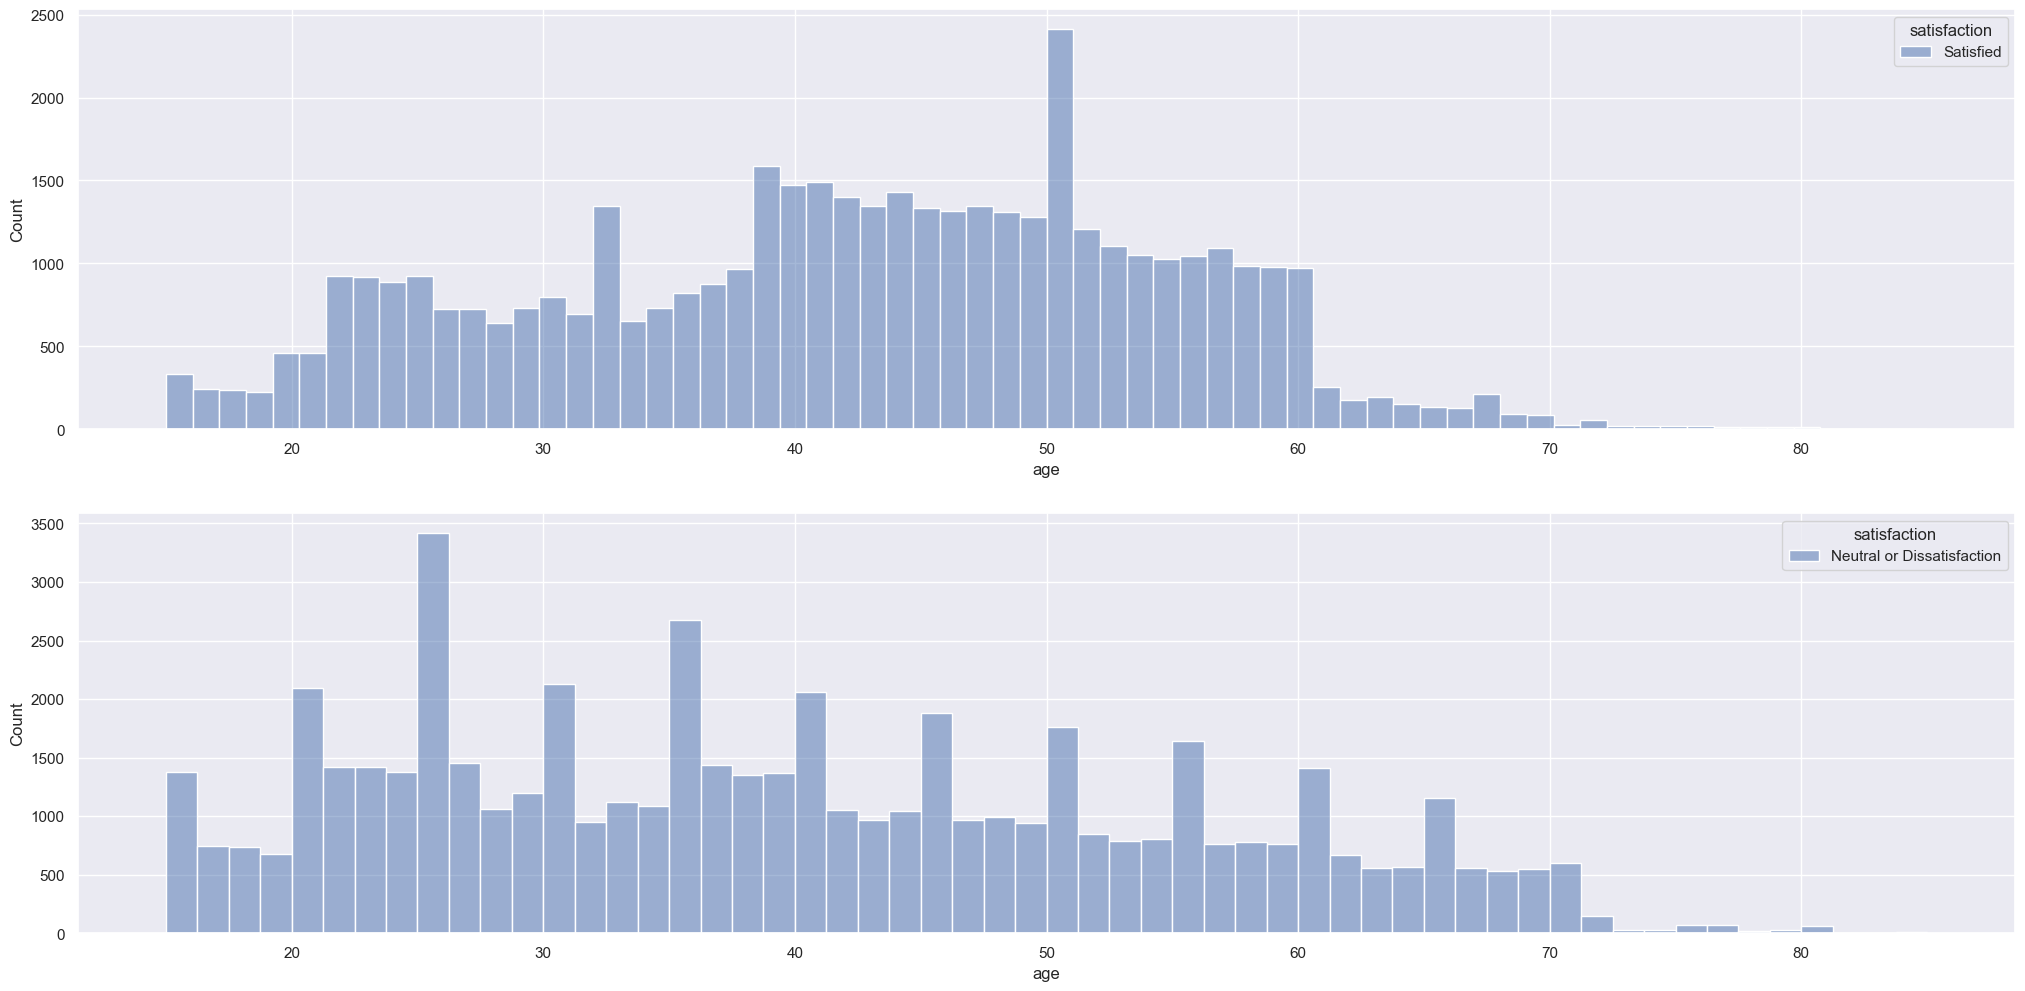

In [99]:
#Age analysis
plt.subplot(2,1,1)
sns.histplot(x='age',
             data=df2[df2['satisfaction'] == 'Satisfied'],
             hue='satisfaction');

plt.subplot(2,1,2)
sns.histplot(x='age',
             data=df2[df2['satisfaction'] == 'Neutral or Dissatisfaction'],
             hue='satisfaction');

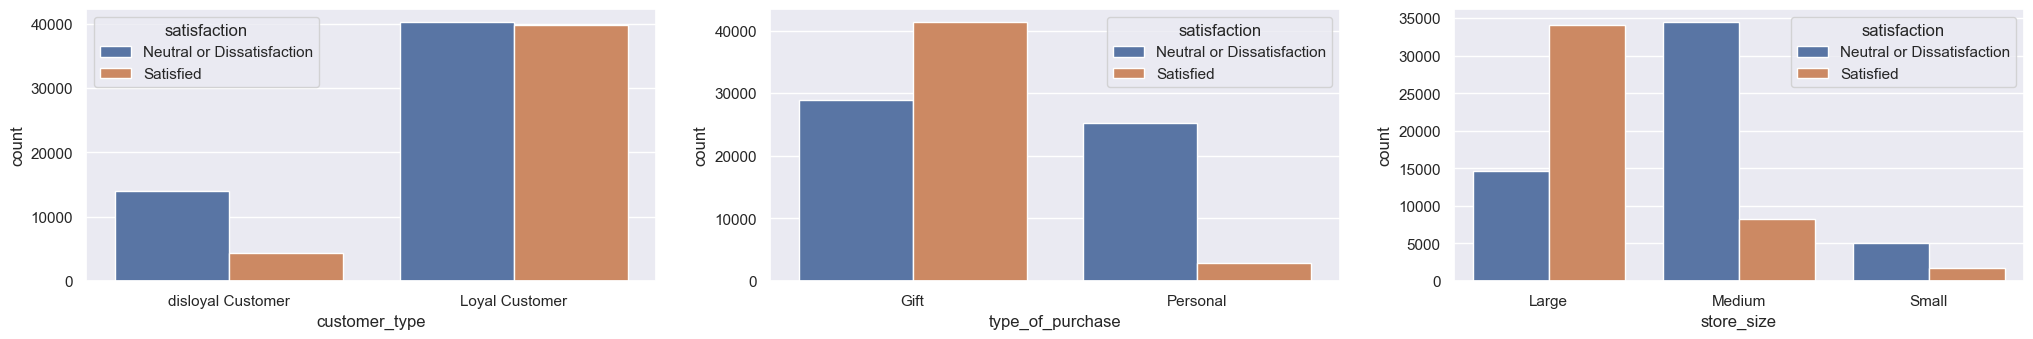

In [100]:
# Categorical analysis

plt.subplot(3,3,1)
sns.countplot(
    x='customer_type',
    hue=('satisfaction'),
    data=df2,
);

plt.subplot(3,3,2)
sns.countplot(
    x='type_of_purchase',
    hue=('satisfaction'),
    data=df2,
);

plt.subplot(3,3,3)
sns.countplot(
     x='store_size',
    hue=('satisfaction'),
    data=df2,
);



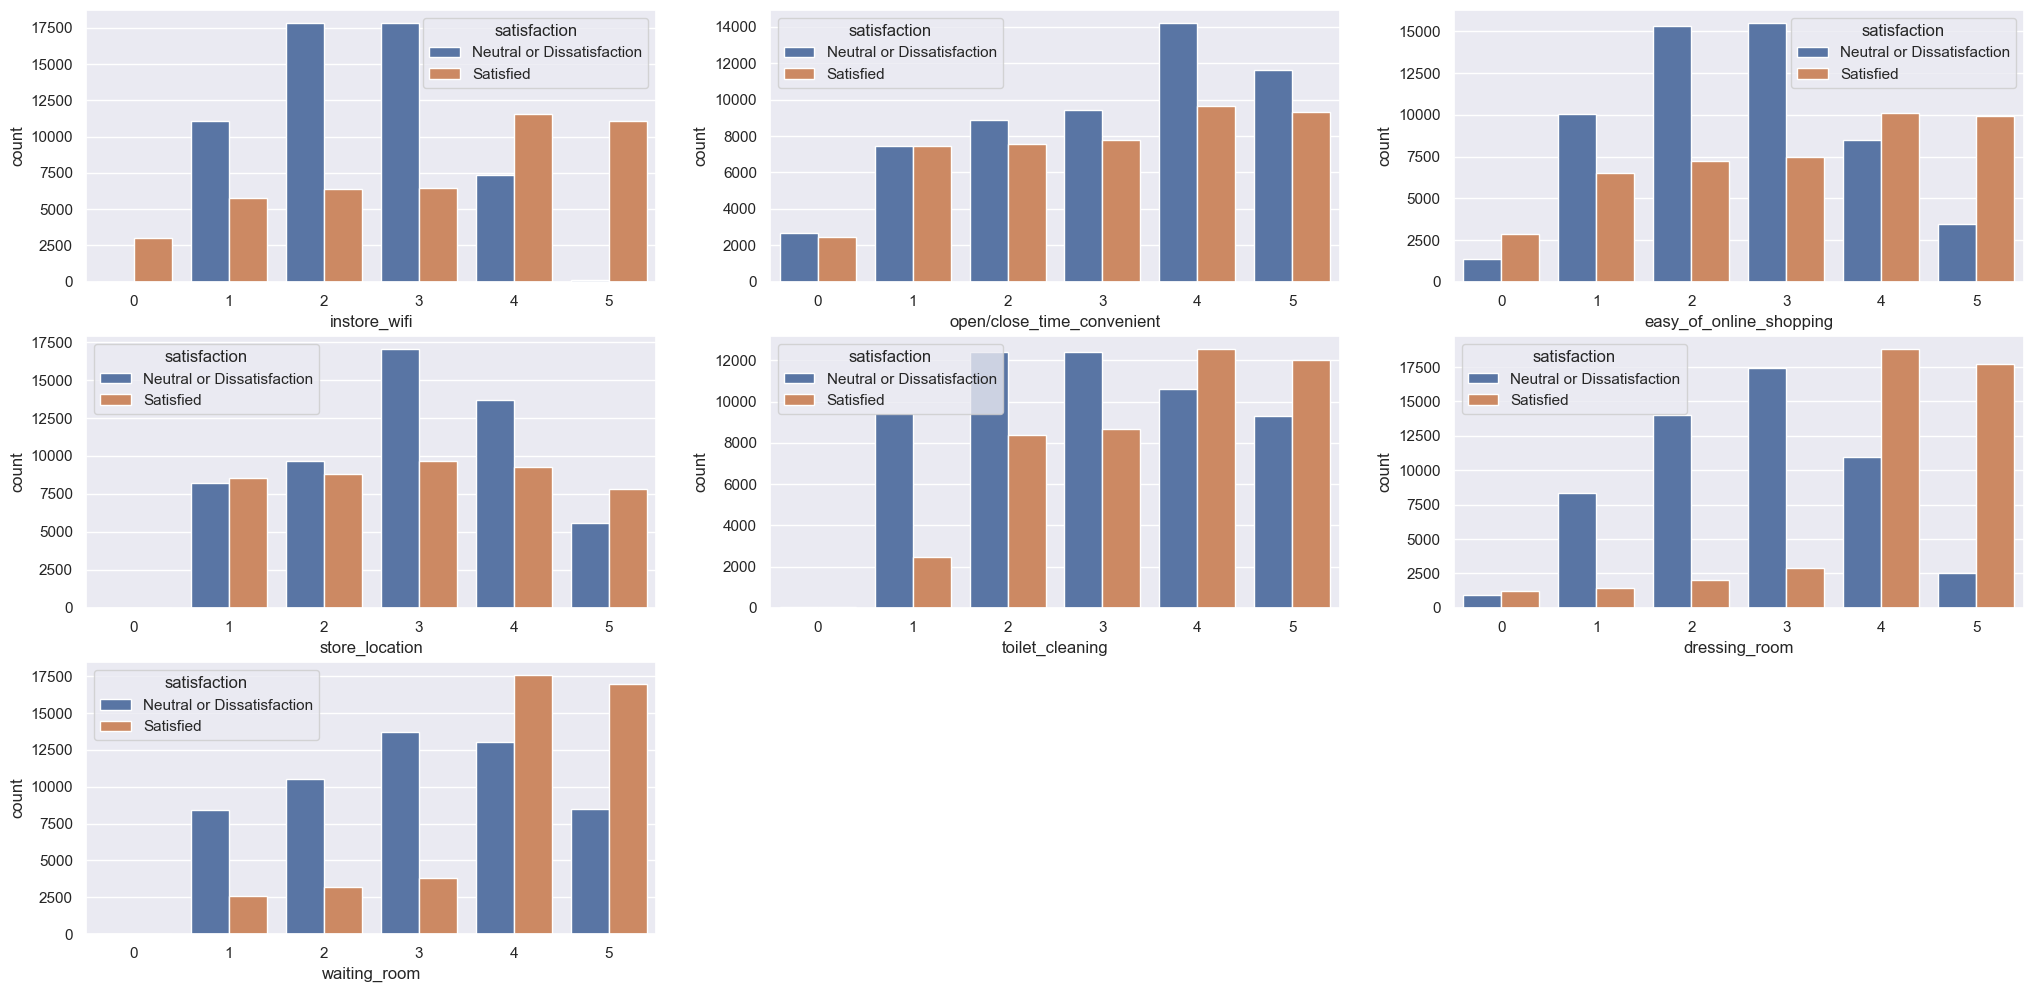

In [101]:
# Ranked analysis

plt.subplot(3,3,1)
sns.countplot(
    x='instore_wifi',
    hue=('satisfaction'),
    data=df2,
);

plt.subplot(3,3,2)
sns.countplot(
    x='open/close_time_convenient',
    hue=('satisfaction'),
    data=df2,
);

plt.subplot(3,3,3)
sns.countplot(
     x='easy_of_online_shopping',
    hue=('satisfaction'),
    data=df2,
);



plt.subplot(3,3,4)
sns.countplot(
     x='store_location',
    hue=('satisfaction'),
    data=df2,
);



plt.subplot(3,3,5)
sns.countplot(
     x='toilet_cleaning',
    hue=('satisfaction'),
    data=df2,
);


plt.subplot(3,3,6)
sns.countplot(
     x='dressing_room',
    hue=('satisfaction'),
    data=df2,
);


plt.subplot(3,3,7)
sns.countplot(
     x='waiting_room',
    hue=('satisfaction'),
    data=df2,
);



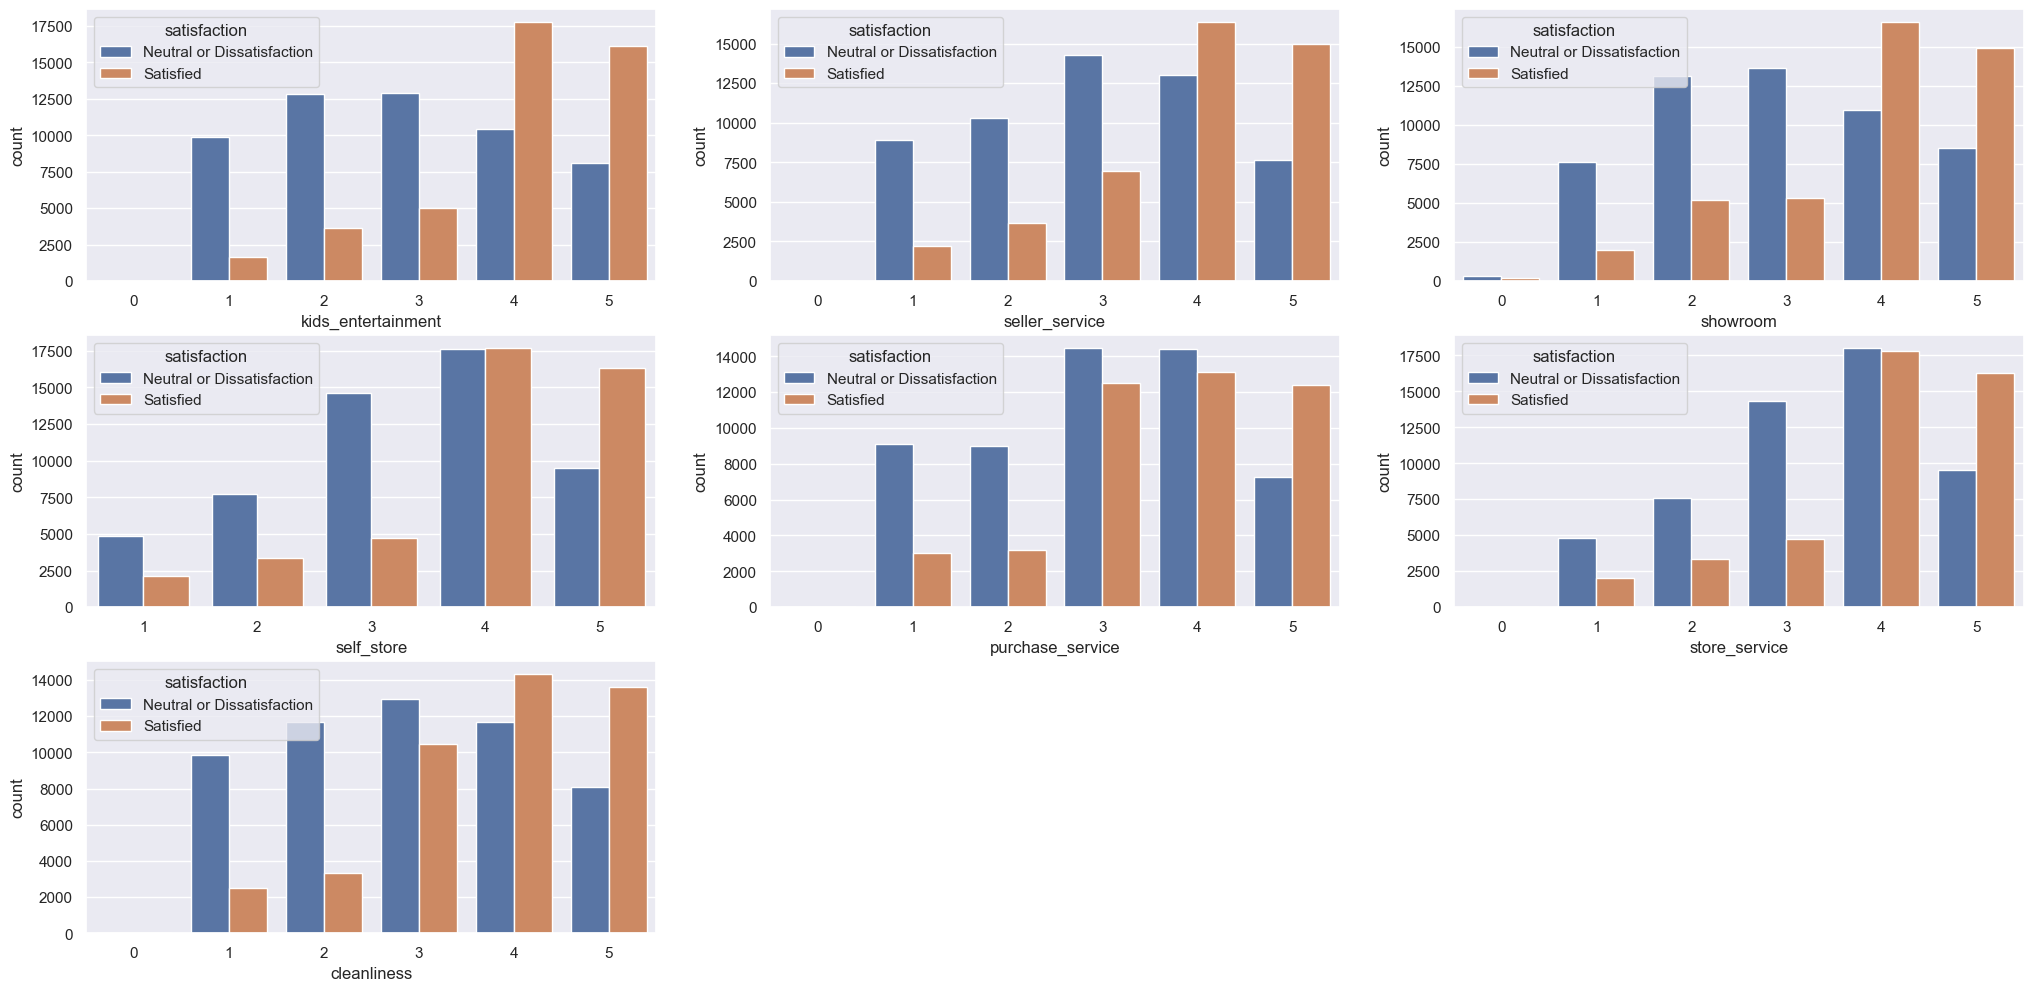

In [102]:
# Ranked analysis

plt.subplot(3,3,1)
sns.countplot(
     x='kids_entertainment',
    hue=('satisfaction'),
    data=df2,
);


plt.subplot(3,3,2)
sns.countplot(
     x='seller_service',
    hue=('satisfaction'),
    data=df2,
);


plt.subplot(3,3,3)
sns.countplot(
     x='showroom',
    hue=('satisfaction'),
    data=df2,
);



plt.subplot(3,3,4)
sns.countplot(
     x='self_store',
    hue=('satisfaction'),
    data=df2,
);


plt.subplot(3,3,5)
sns.countplot(
     x='purchase_service',
    hue=('satisfaction'),
    data=df2,
);

plt.subplot(3,3,6)
sns.countplot(
     x='store_service',
    hue=('satisfaction'),
    data=df2,
);

plt.subplot(3,3,7)
sns.countplot(
     x='cleanliness',
    hue=('satisfaction'),
    data=df2,
);

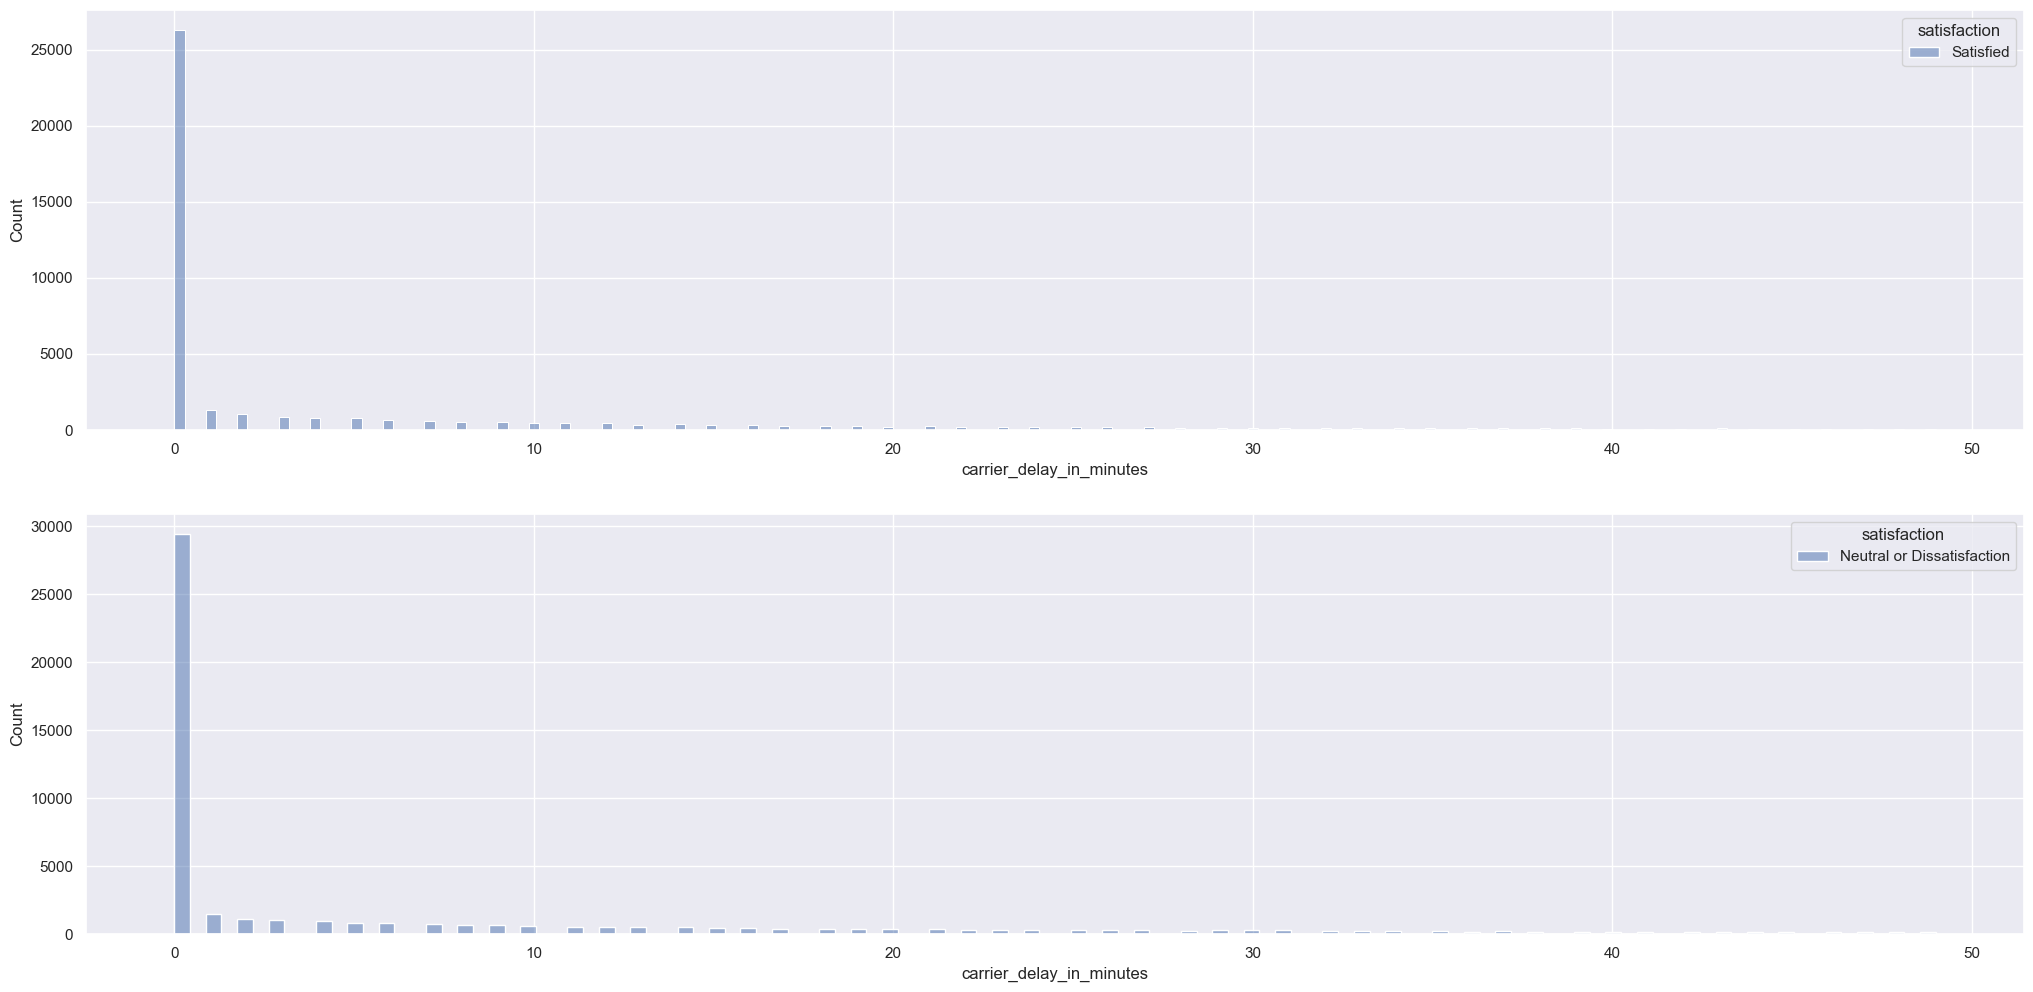

In [103]:
# 'carrier_delay_in_minutes' com tempo menor que 50 min
plt.subplot(2,1,1)
sns.histplot(x='carrier_delay_in_minutes',
             data=df2[(df2['satisfaction'] == 'Satisfied') & (df2['carrier_delay_in_minutes'] < 50)],
             hue='satisfaction');

plt.subplot(2,1,2)
sns.histplot(x='carrier_delay_in_minutes',
             data=df2[(df2['satisfaction'] == 'Neutral or Dissatisfaction') & (df2['carrier_delay_in_minutes'] < 50)],
             hue='satisfaction');

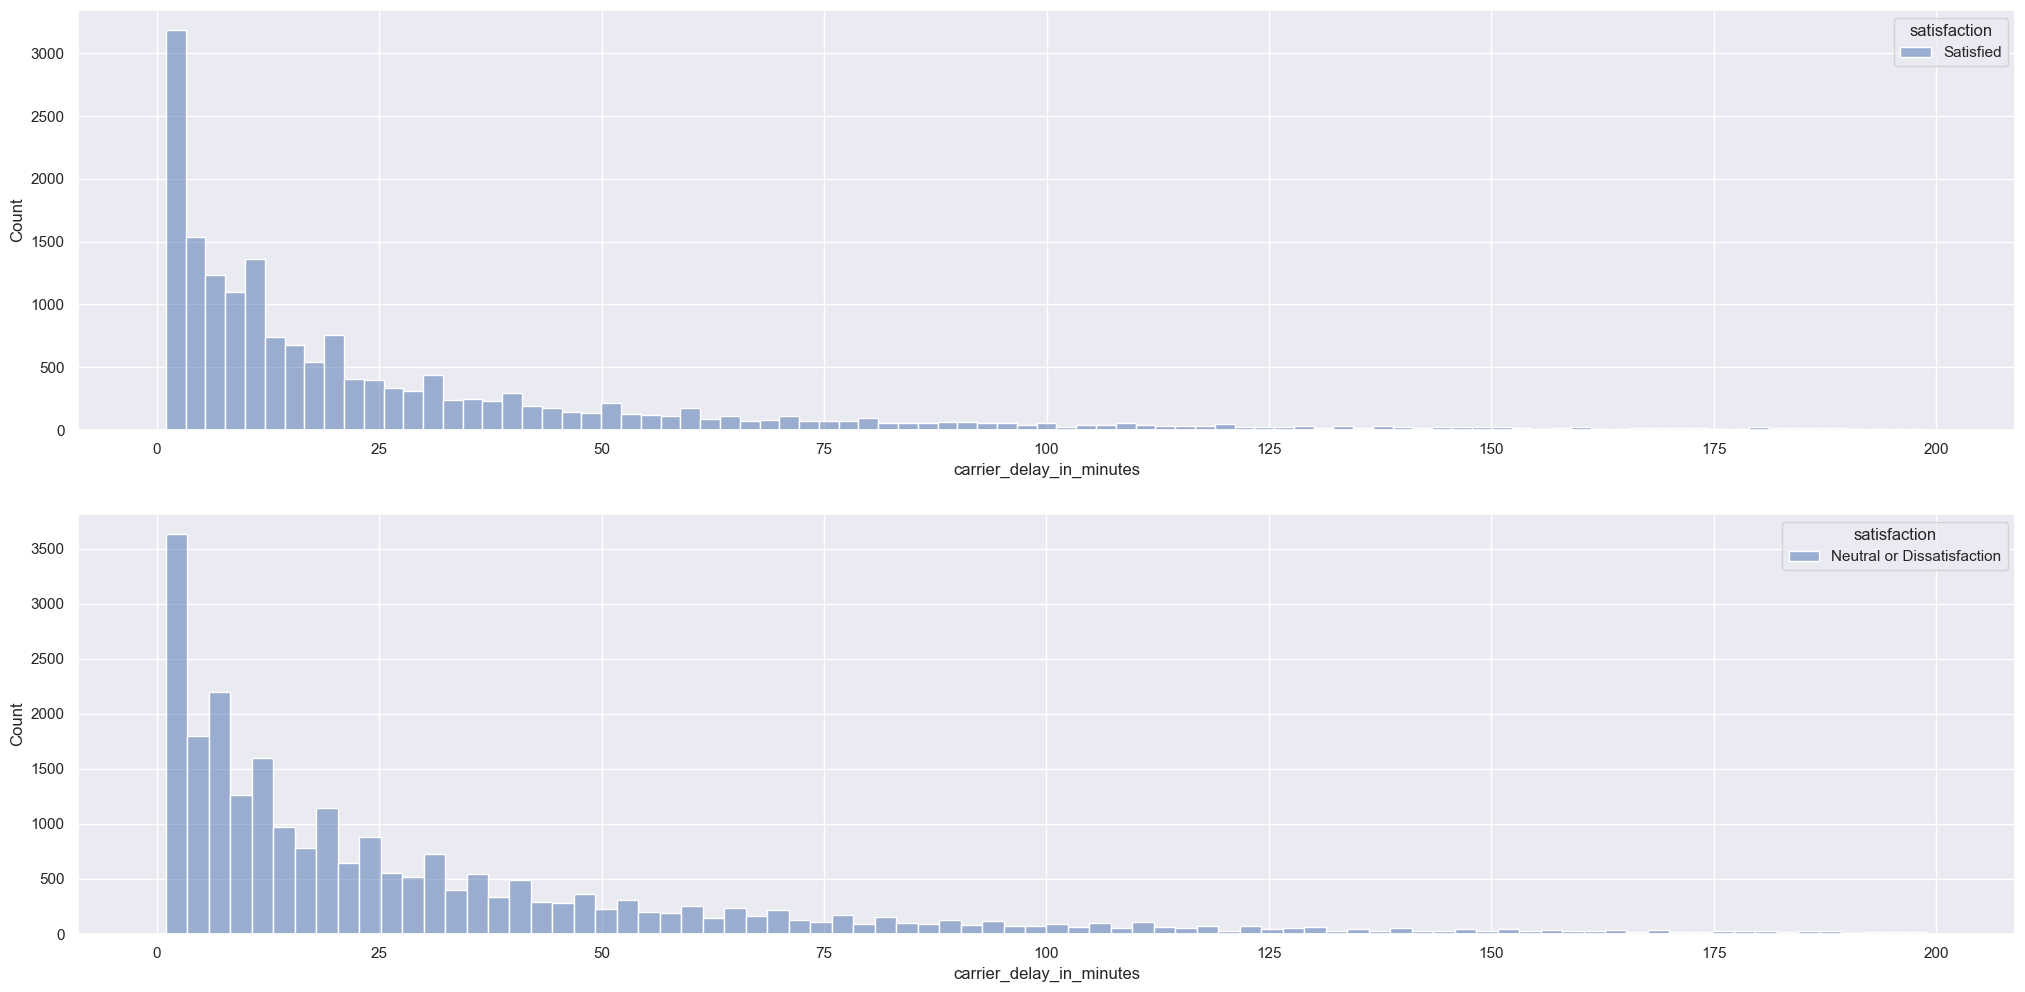

In [104]:
# 'carrier_delay_in_minutes' com tempo maior que 0 e menor que 200 min 

plt.subplot(2,1,1)
sns.histplot(x='carrier_delay_in_minutes',
             data=df2[(df2['satisfaction'] == 'Satisfied') & (df2['carrier_delay_in_minutes'] > 0) & (df2['carrier_delay_in_minutes'] < 200)],
             hue='satisfaction');

plt.subplot(2,1,2)
sns.histplot(x='carrier_delay_in_minutes',
             data=df2[(df2['satisfaction'] == 'Neutral or Dissatisfaction') & (df2['carrier_delay_in_minutes'] > 0) & (df2['carrier_delay_in_minutes'] < 200)],
             hue='satisfaction');

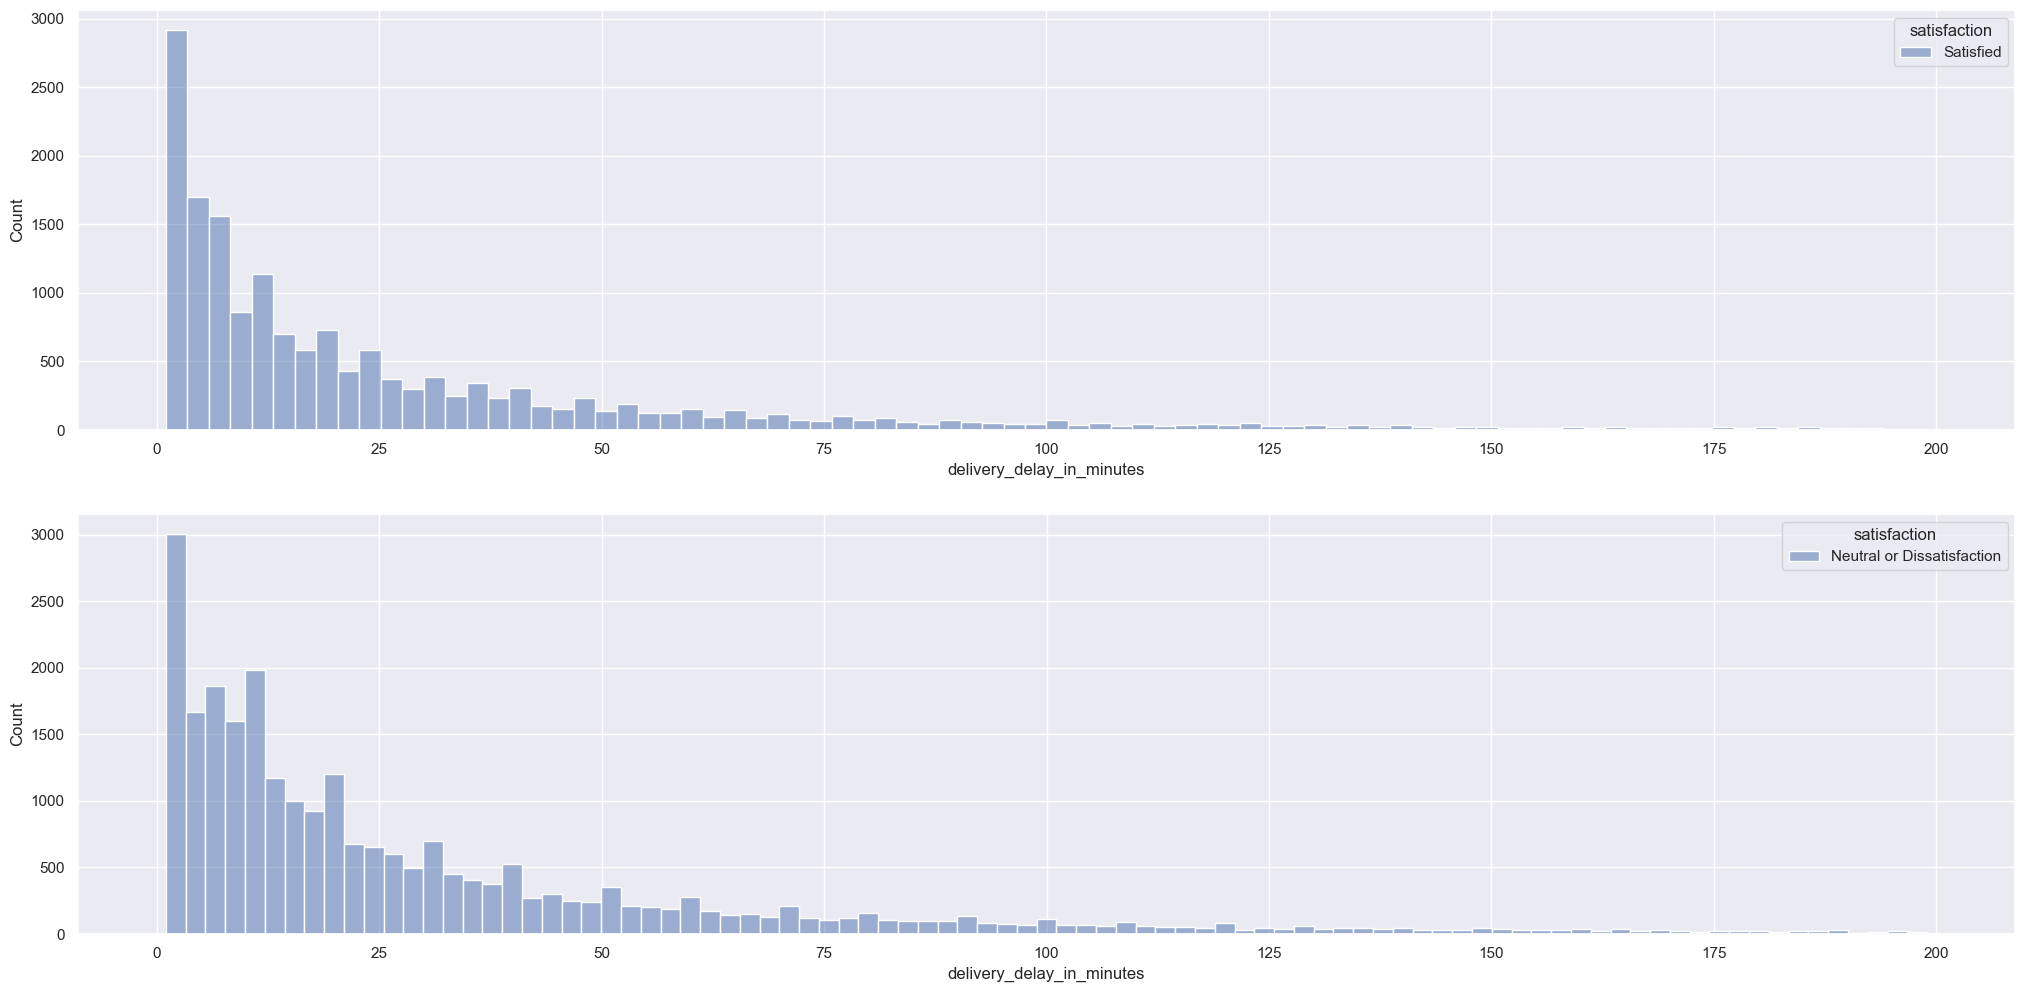

In [105]:
# 'delivery_delay_in_minutes' com tempo maior que 0 e menor que 200 min 
plt.subplot(2,1,1)
sns.histplot(x='delivery_delay_in_minutes',
             data=df2[(df2['satisfaction'] == 'Satisfied') & (df2['delivery_delay_in_minutes'] > 0) & (df2['delivery_delay_in_minutes'] < 200)],
             hue='satisfaction');

plt.subplot(2,1,2)
sns.histplot(x='delivery_delay_in_minutes',
             data=df2[(df2['satisfaction'] == 'Neutral or Dissatisfaction') & (df2['delivery_delay_in_minutes'] > 0) & (df2['delivery_delay_in_minutes'] < 200)],
             hue='satisfaction');

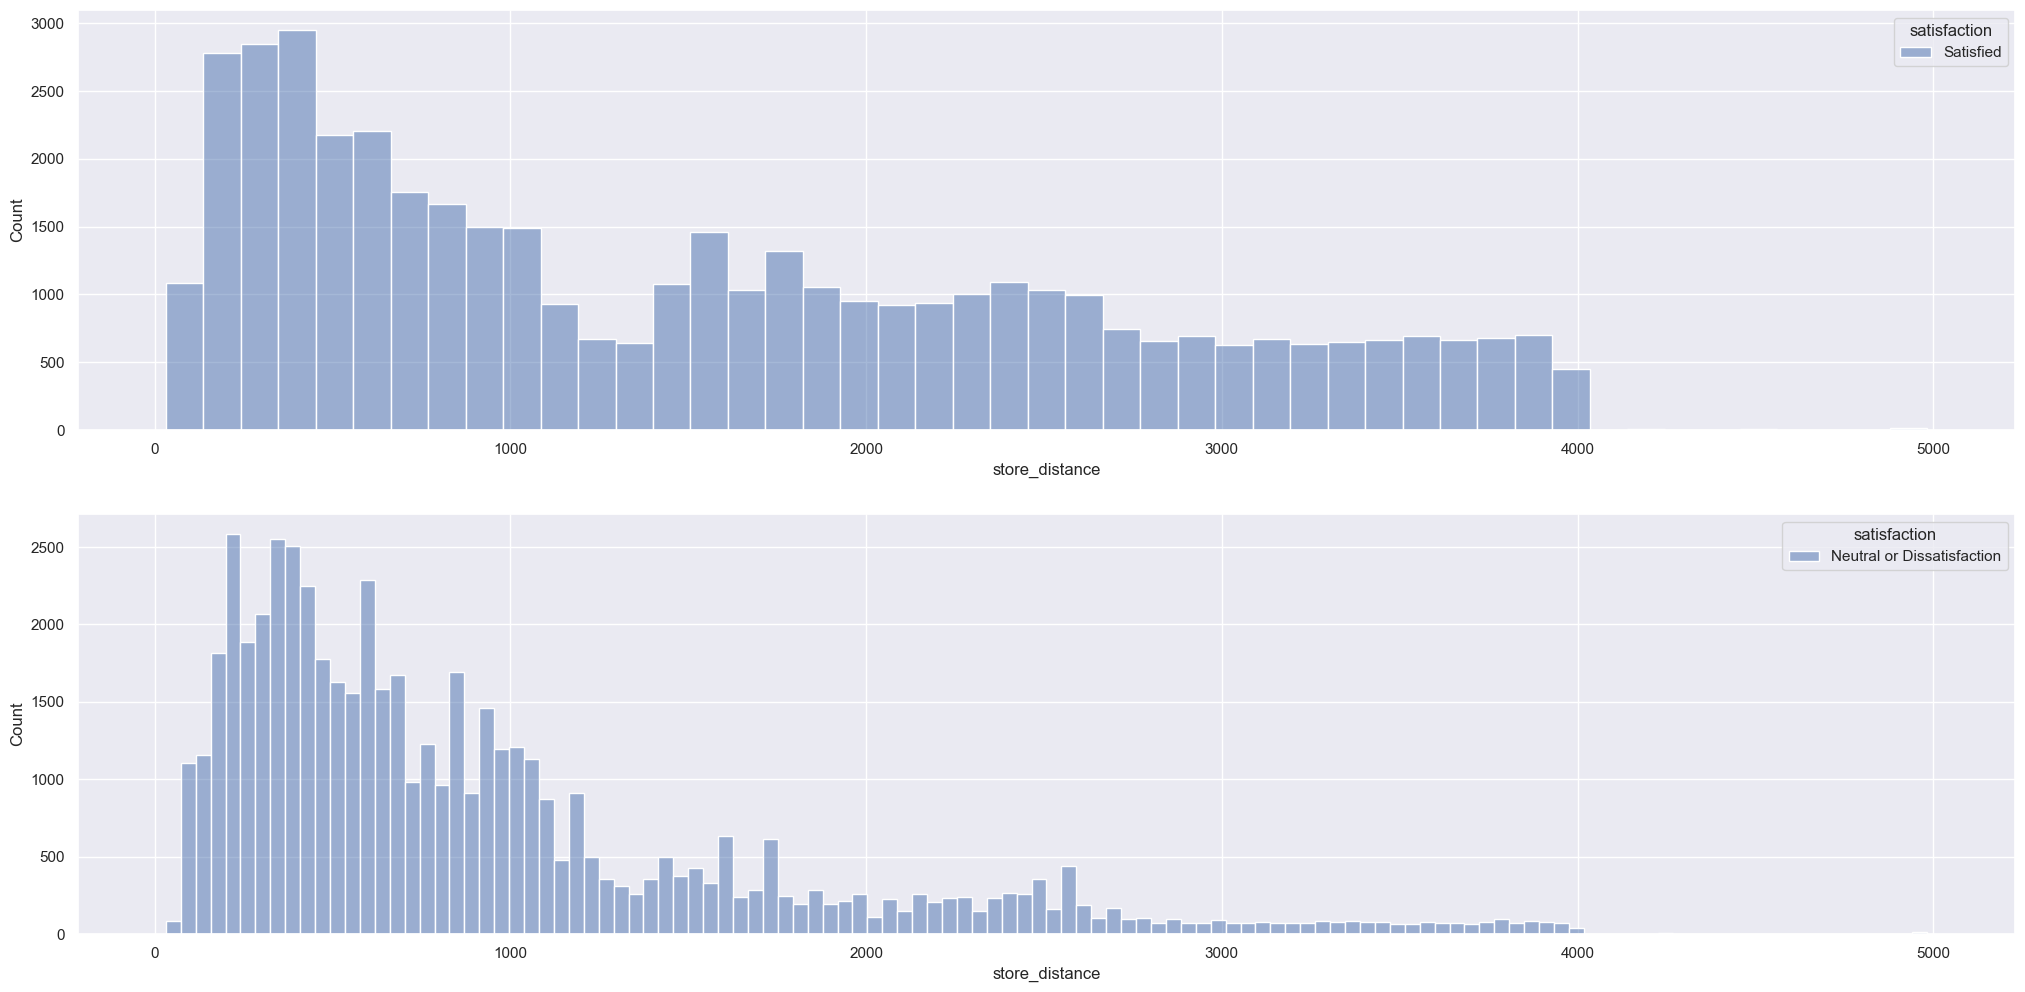

In [106]:
# Satisfação em relação à distância da loja 

plt.subplot(2,1,1)
sns.histplot(x='store_distance',
             data=df2[(df2['satisfaction'] == 'Satisfied')],
             hue='satisfaction');

plt.subplot(2,1,2)
sns.histplot(x='store_distance',
             data=df2[(df2['satisfaction'] == 'Neutral or Dissatisfaction')],
             hue='satisfaction');

### New Features

In [107]:
df3=df2.copy()

In [108]:
# carrier_delay (no = 0 yes > 1)
df3['carrier_delay'] = df3[['carrier_delay_in_minutes']].apply(lambda x: 'no' if x['carrier_delay_in_minutes'] == 0 else 'yes', axis=1)

# delivery_delay (no = 0 yes > 1)
df3['delivery_delay'] = df3[['delivery_delay_in_minutes']].apply(lambda x: 'no' if x['delivery_delay_in_minutes'] == 0 else 'yes', axis=1)

# carrier_delay_ (0 < x < 10 10 < x < 20 20 < x < 30 30 < x < 60 60 > x)
def transform_delay(x):
    if x == 0:
        return '0'
    elif x <= 10:
        return '<10'
    elif x <= 20:
        return '<20'
    elif x <= 30:
        return '<30'
    elif x <= 60:
        return '<60'
    else:
        return '>60'

df3['carrier_delay_in_min'] = df3['carrier_delay_in_minutes'].apply(transform_delay)

df3['delivery_delay_in_min'] = df3['delivery_delay_in_minutes'].apply(transform_delay)


# Soma dos atrasos
df3['delivery_delay_in_minutes'] = df3['delivery_delay_in_minutes'].astype(int)
df3['sum_delay_in_minute'] = df3['delivery_delay_in_minutes'] + df3['carrier_delay_in_minutes']


# Subtração dos atrasos.
df3['sub_delay_in_minute'] = df3['delivery_delay_in_minutes'] - df3['carrier_delay_in_minutes']
df3['sub_delay_in_minute'] = np.where(df3['sub_delay_in_minute'] <= 0, 0, df3['sub_delay_in_minute'])


# carrier_delay_in_hour
df3['carrier_delay_in_hour'] = df3['carrier_delay_in_minutes'].apply(lambda x: x/60)

#delivery_delay_in_hour
df3['delivery_delay_in_hour'] = df3['delivery_delay_in_minutes'].apply(lambda x: x/60)

In [109]:
df3.head(5)

,id,gender,customer_type,age,type_of_purchase,store_size,store_distance,instore_wifi,open/close_time_convenient,easy_of_online_shopping,store_location,toilet_cleaning,dressing_room,waiting_room,kids_entertainment,seller_service,showroom,self_store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes,satisfaction,carrier_delay,delivery_delay,carrier_delay_in_min,delivery_delay_in_min,sum_delay_in_minute,sub_delay_in_minute,carrier_delay_in_hour,delivery_delay_in_hour
1,5047,Male,disloyal Customer,25,Gift,Large,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6,Neutral or Dissatisfaction,yes,yes,<10,<10,7,5,0.016667,0.10
2,110028,Female,Loyal Customer,26,Gift,Large,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0,Satisfied,no,no,0,0,0,0,0.000000,0.00
3,24026,Female,Loyal Customer,25,Gift,Large,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9,Neutral or Dissatisfaction,yes,yes,<20,<10,20,0,0.183333,0.15
4,119299,Male,Loyal Customer,61,Gift,Large,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0,Satisfied,no,no,0,0,0,0,0.000000,0.00
5,111157,Female,Loyal Customer,26,Personal,Medium,1180,3,4,2,1,1,2,1,1,3,4,4,4,4,1,0,0,Neutral or Dissatisfaction,no,no,0,0,0,0,0.000000,0.00


In [110]:
# df3['delivery_delay_in_minutes'] = df3['delivery_delay_in_minutes'].astype(int)
df3['sub_delay_in_minute'] = df3['delivery_delay_in_minutes'] - df3['carrier_delay_in_minutes']
df3['sub_delay_in_minute'] = np.where(df3['sub_delay_in_minute'] <= 0, 0, df3['sub_delay_in_minute'])


In [111]:
df2[df2['store_distance'] < 100].head()

,id,gender,customer_type,age,type_of_purchase,store_size,store_distance,instore_wifi,open/close_time_convenient,easy_of_online_shopping,store_location,toilet_cleaning,dressing_room,waiting_room,kids_entertainment,seller_service,showroom,self_store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes,satisfaction
258,44736,Female,Loyal Customer,72,Gift,Small,67,2,5,3,5,2,3,4,3,3,2,3,4,3,3,28,18.0,Neutral or Dissatisfaction
273,1150,Female,Loyal Customer,15,Personal,Medium,89,3,5,3,4,5,3,1,5,5,5,4,3,5,5,0,0.0,Neutral or Dissatisfaction
357,46695,Female,Loyal Customer,44,Personal,Medium,73,2,3,2,3,4,3,4,1,1,2,1,2,1,1,0,32.0,Neutral or Dissatisfaction
494,120723,Female,Loyal Customer,49,Gift,Large,90,4,4,2,4,3,4,4,4,4,4,4,4,4,3,0,0.0,Satisfied
600,44731,Male,Loyal Customer,40,Gift,Small,67,4,4,5,5,4,4,4,4,2,1,1,4,4,4,0,4.0,Satisfied


In [112]:
df3.head(3)

,id,gender,customer_type,age,type_of_purchase,store_size,store_distance,instore_wifi,open/close_time_convenient,easy_of_online_shopping,store_location,toilet_cleaning,dressing_room,waiting_room,kids_entertainment,seller_service,showroom,self_store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes,satisfaction,carrier_delay,delivery_delay,carrier_delay_in_min,delivery_delay_in_min,sum_delay_in_minute,sub_delay_in_minute,carrier_delay_in_hour,delivery_delay_in_hour
1,5047,Male,disloyal Customer,25,Gift,Large,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6,Neutral or Dissatisfaction,yes,yes,<10,<10,7,5,0.016667,0.10
2,110028,Female,Loyal Customer,26,Gift,Large,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0,Satisfied,no,no,0,0,0,0,0.000000,0.00
3,24026,Female,Loyal Customer,25,Gift,Large,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9,Neutral or Dissatisfaction,yes,yes,<20,<10,20,0,0.183333,0.15


### New Features Evaluation

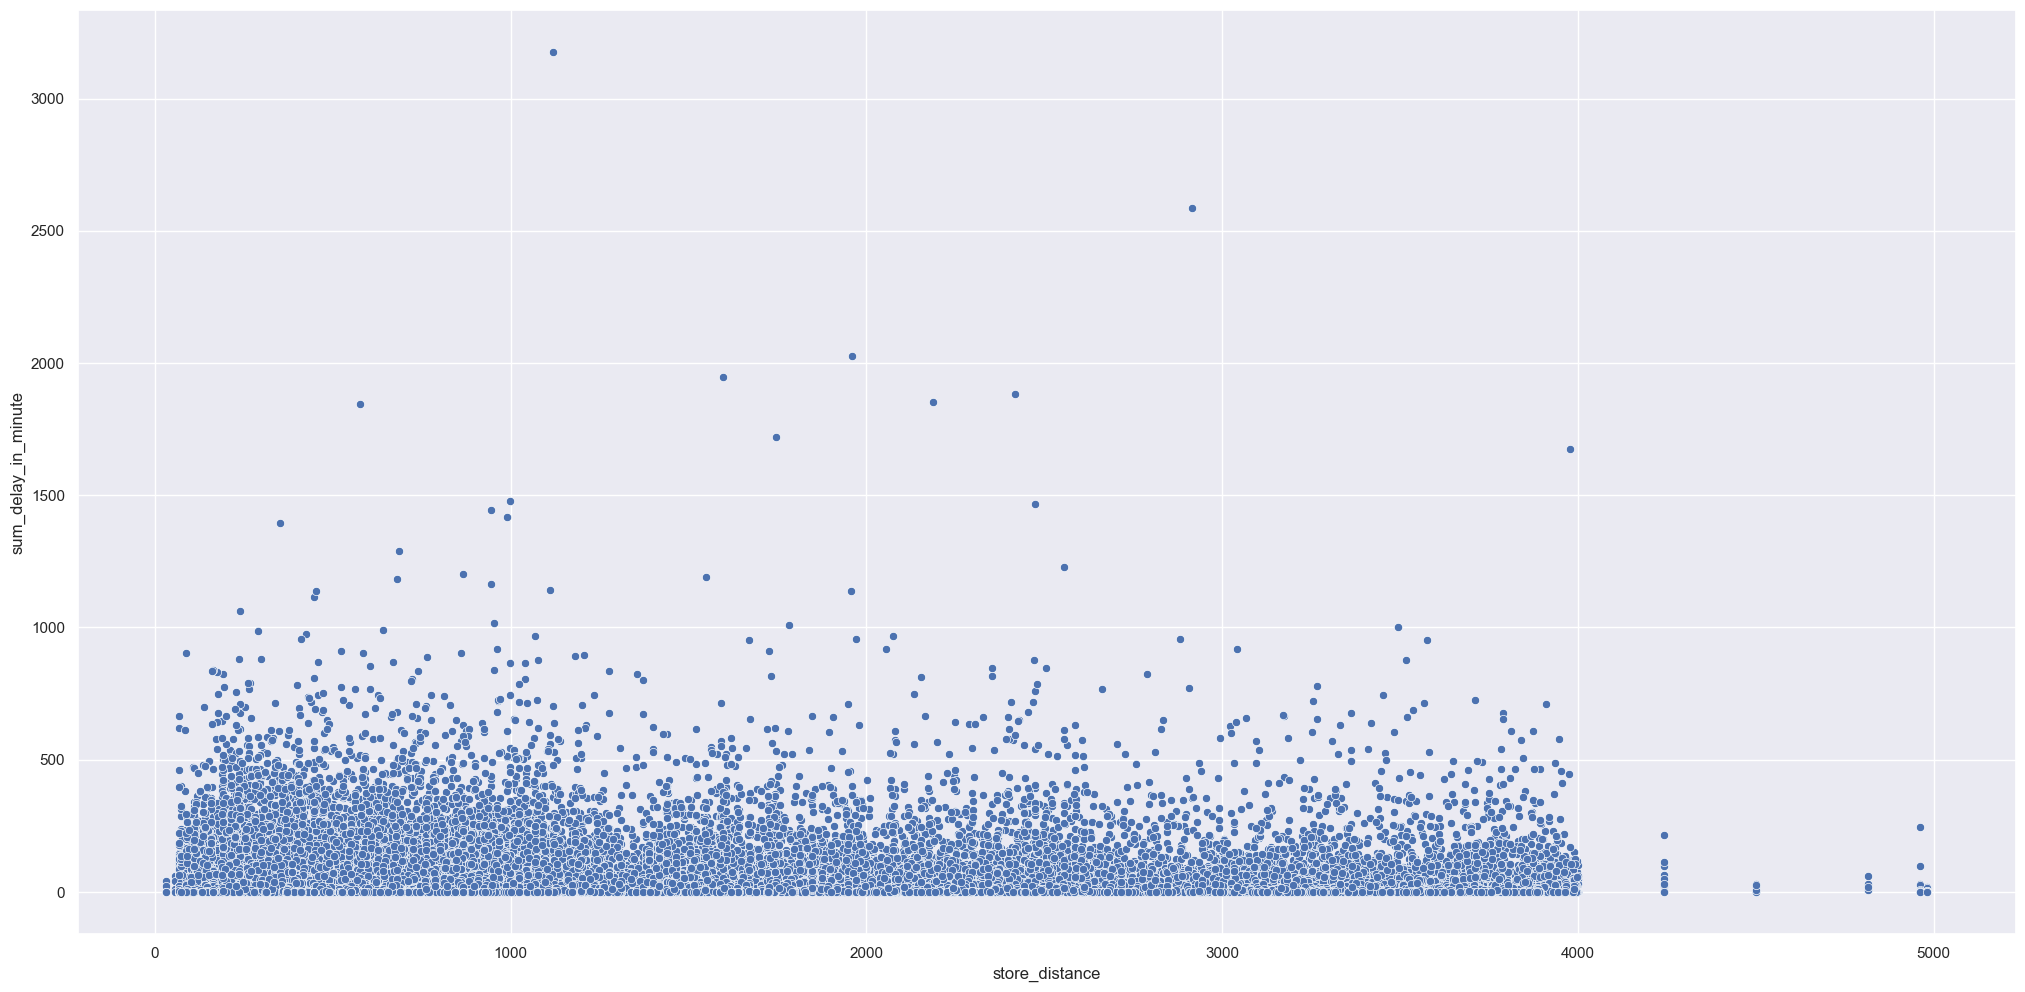

In [113]:
sns.scatterplot( x='store_distance', y='sum_delay_in_minute', data=df3);

In [114]:
df3.head(3)

,id,gender,customer_type,age,type_of_purchase,store_size,store_distance,instore_wifi,open/close_time_convenient,easy_of_online_shopping,store_location,toilet_cleaning,dressing_room,waiting_room,kids_entertainment,seller_service,showroom,self_store,purchase_service,store_service,cleanliness,carrier_delay_in_minutes,delivery_delay_in_minutes,satisfaction,carrier_delay,delivery_delay,carrier_delay_in_min,delivery_delay_in_min,sum_delay_in_minute,sub_delay_in_minute,carrier_delay_in_hour,delivery_delay_in_hour
1,5047,Male,disloyal Customer,25,Gift,Large,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6,Neutral or Dissatisfaction,yes,yes,<10,<10,7,5,0.016667,0.10
2,110028,Female,Loyal Customer,26,Gift,Large,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0,Satisfied,no,no,0,0,0,0,0.000000,0.00
3,24026,Female,Loyal Customer,25,Gift,Large,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9,Neutral or Dissatisfaction,yes,yes,<20,<10,20,0,0.183333,0.15


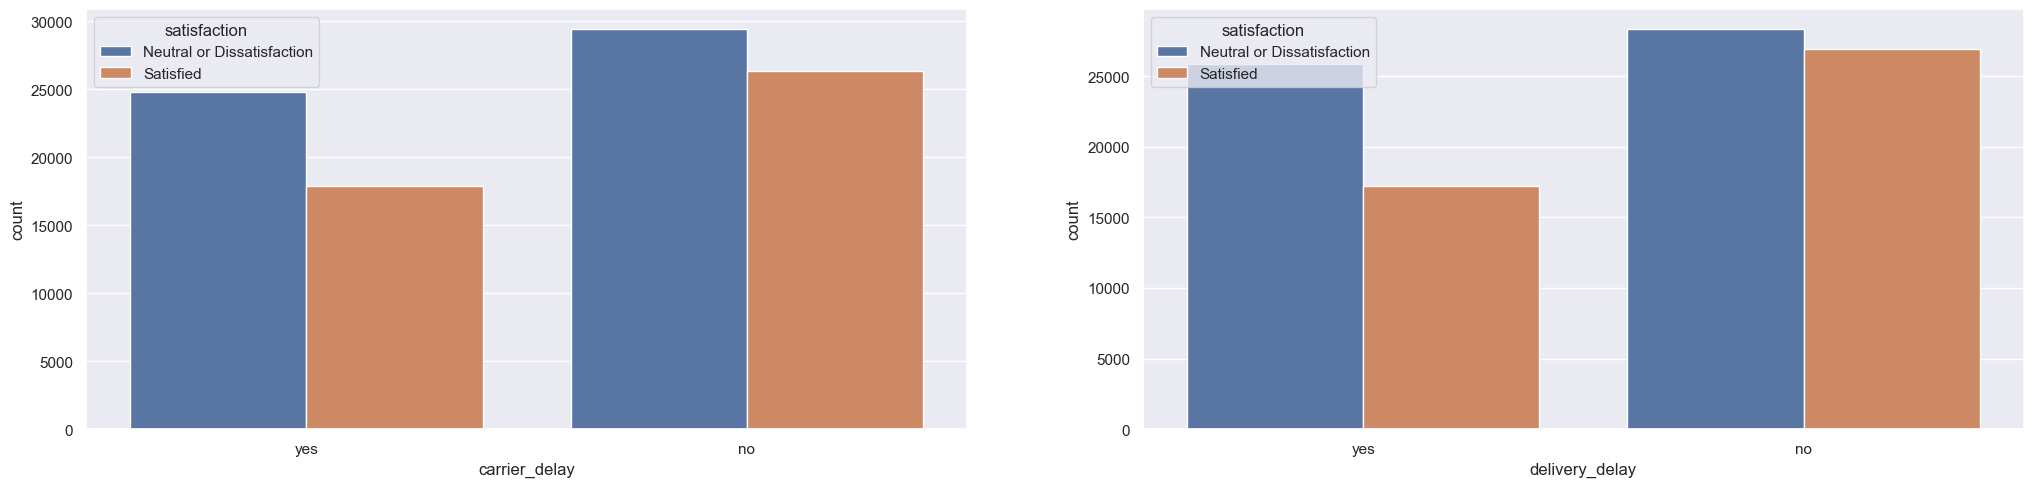

In [115]:
# Categorical analysis

plt.subplot(2,2,1)
sns.countplot(
    x='carrier_delay',
    hue=('satisfaction'),
    data=df3,
);

plt.subplot(2,2,2)
sns.countplot(
    x='delivery_delay',
    hue=('satisfaction'),
    data=df3,
);

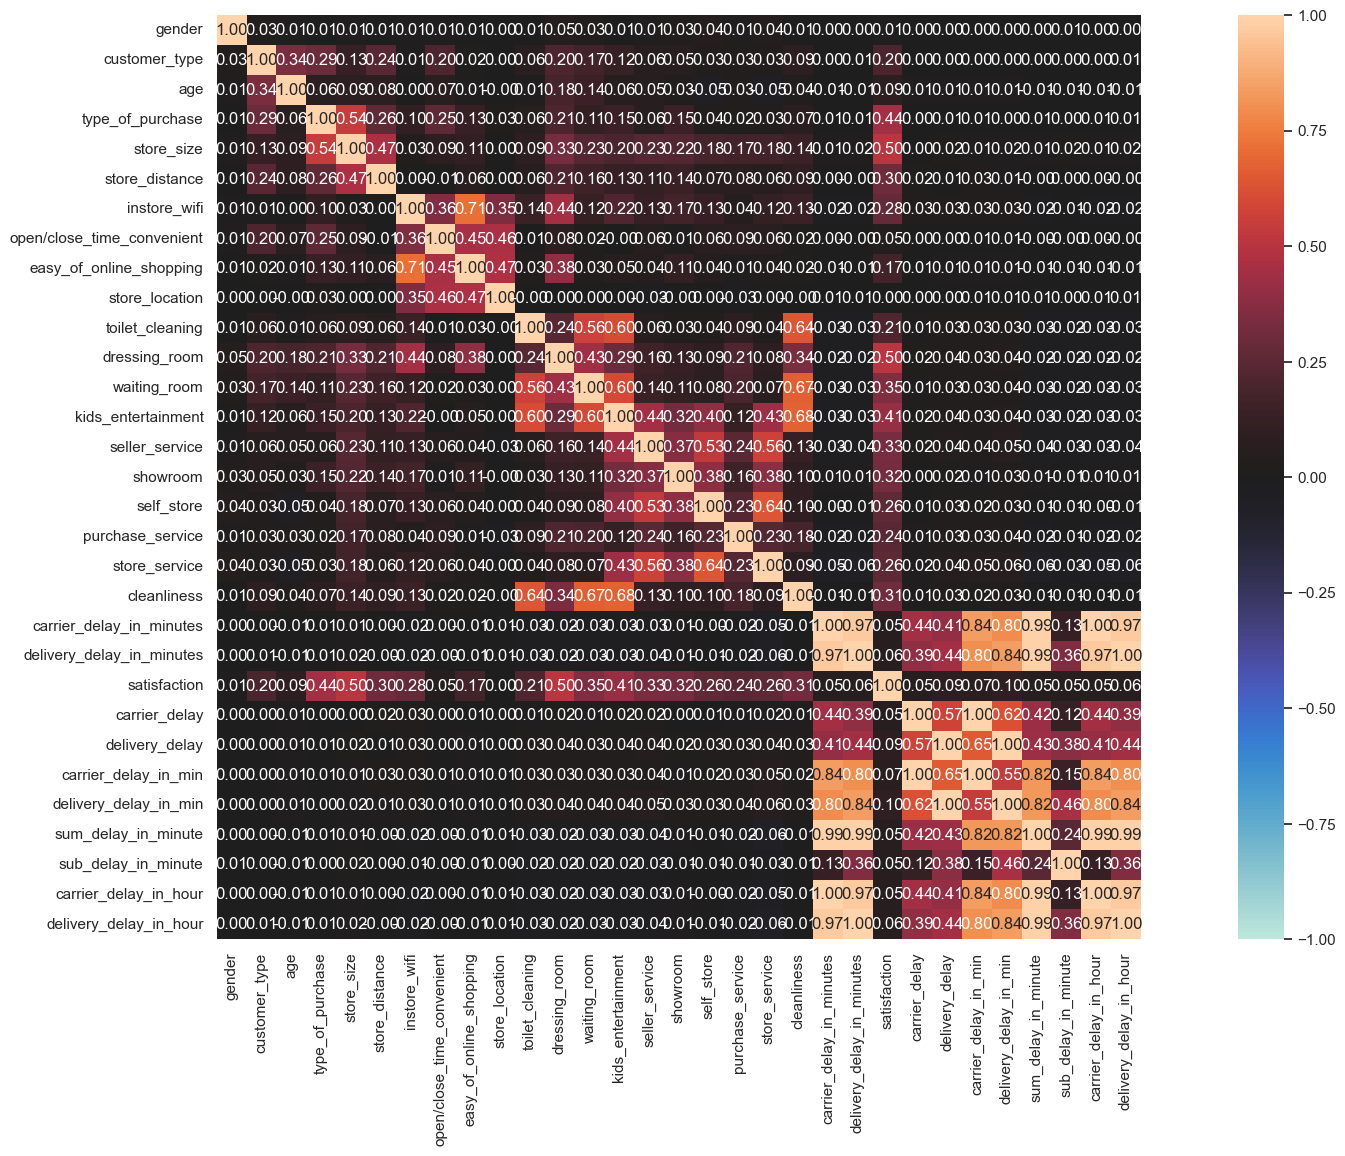

In [116]:
nominal.associations(df3.drop('id',axis = 1));

# Data Preparation

In [117]:
df4 = df3.copy()

### Split

In [118]:
x = df4.drop(['id','satisfaction'], axis=1)
y = df4['satisfaction']

In [119]:
# Dataset (100%) -> Treino(80%) e Teste(20%)
x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size=0.20)

In [120]:
# Treino(80%) -> treino(60%) e validação(20%)
x_train, x_validation, y_train, y_validation = ms.train_test_split(x_train, y_train, test_size=0.20) 
df_train = pd.concat([x_train, y_train], axis=1) # juntar as variaveis preditoras com a variavel alvo

### Tranformations

In [121]:
# MinMaxscaler - age, carrier_delay_in_minutes, delivery_delay_in_minutes,   sum_delay_in_minute ,sub_delay_in_minute, delivery_delay_in_hour, carrier_delay_in_hour

mms = MinMaxScaler()

df_train['age'] = mms.fit_transform(df_train[['age']].values)

In [122]:
# RobustScaler - age, carrier_delay_in_minutes delivery_delay_in_minutes,    sum_delay_in_minute sub_delay_in_minute delivery_delay_in_hour carrier_delay_in_hour

rs = RobustScaler()

df_train['carrier_delay_in_minutes'] = rs.fit_transform(df_train[['carrier_delay_in_minutes']].values)
df_train['delivery_delay_in_minutes'] = rs.fit_transform(df_train[['delivery_delay_in_minutes']].values)
df_train['sum_delay_in_minute'] = rs.fit_transform(df_train[['sum_delay_in_minute']].values)
df_train['sub_delay_in_minute'] = rs.fit_transform(df_train[['sub_delay_in_minute']].values)
df_train['delivery_delay_in_hour'] = rs.fit_transform(df_train[['delivery_delay_in_hour']].values)
df_train['carrier_delay_in_hour'] = rs.fit_transform(df_train[['carrier_delay_in_hour']].values)



In [123]:
# Label encoder - gender, customer_type, type_of_purchase, store_size, carrier_delay, delivery_delay, carrier_delay_in_min, delivery_delay_in_min

# Crie uma instância do LabelEncoder
le = LabelEncoder()

# Ajuste e transforme a coluna 'gender' do DataFrame
df_train['carrier_delay_in_min'] = le.fit_transform(df_train['carrier_delay_in_min'])
df_train['delivery_delay_in_min'] = le.fit_transform(df_train['delivery_delay_in_min'])
df_train['gender'] = le.fit_transform(df_train['gender'])
df_train['customer_type'] = le.fit_transform(df_train['customer_type'])
df_train['type_of_purchase'] = le.fit_transform(df_train['type_of_purchase'])
df_train['store_size'] = le.fit_transform(df_train['store_size'])
df_train['carrier_delay'] = le.fit_transform(df_train['carrier_delay'])
df_train['delivery_delay'] = le.fit_transform(df_train['delivery_delay'])



#### Data Preparation - Validação

In [135]:
x_validation['age'] = mms.fit_transform(x_validation[['age']].values)

x_validation['carrier_delay_in_minutes'] = rs.fit_transform(x_validation[['carrier_delay_in_minutes']].values)
x_validation['delivery_delay_in_minutes'] = rs.fit_transform(x_validation[['delivery_delay_in_minutes']].values)
x_validation['sum_delay_in_minute'] = rs.fit_transform(x_validation[['sum_delay_in_minute']].values)
x_validation['sub_delay_in_minute'] = rs.fit_transform(x_validation[['sub_delay_in_minute']].values)
x_validation['delivery_delay_in_hour'] = rs.fit_transform(x_validation[['delivery_delay_in_hour']].values)
x_validation['carrier_delay_in_hour'] = rs.fit_transform(x_validation[['carrier_delay_in_hour']].values)

x_validation['carrier_delay_in_min'] = le.fit_transform(x_validation['carrier_delay_in_min'])
x_validation['delivery_delay_in_min'] = le.fit_transform(x_validation['delivery_delay_in_min'])
x_validation['gender'] = le.fit_transform(x_validation['gender'])
x_validation['customer_type'] = le.fit_transform(x_validation['customer_type'])
x_validation['type_of_purchase'] = le.fit_transform(x_validation['type_of_purchase'])
x_validation['store_size'] = le.fit_transform(x_validation['store_size'])
x_validation['carrier_delay'] = le.fit_transform(x_validation['carrier_delay'])
x_validation['delivery_delay'] = le.fit_transform(x_validation['delivery_delay'])

### Features selection

In [124]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)
# rfc = RandomForestClassifier(n_jobs=-1, random_state=42)
# XGBClassifier(n_jobs=-1,  random_state=42, max_delta_step=1, eval_metric='binary:logistic')
# lgbm.LGBMClassifier(n_jobs=-1,  random_state=42)

# data preparation
x_train_n = df_train.drop(['satisfaction'], axis=1)
y_train_n = y_train.values

forest.fit(x_train_n, y_train_n)
# rfc.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking
                      feature  importance
0            type_of_purchase    0.132892
0                instore_wifi    0.120524
0               dressing_room    0.119828
0                  store_size    0.085301
0               customer_type    0.055478
0          kids_entertainment    0.051914
0                waiting_room    0.049355
0     easy_of_online_shopping    0.040412
0                    showroom    0.037706
0              seller_service    0.033857
0                 cleanliness    0.033066
0                  self_store    0.032624
0            purchase_service    0.029807
0               store_service    0.029736
0              store_distance    0.023730
0                         age    0.020020
0  open/close_time_convenient    0.019325
0              store_location    0.017644
0             toilet_cleaning    0.014671
0                      gender    0.007240
0         sum_delay_in_minute    0.005893
0       carrier_delay_in_hour    0.005015
0    carrier_delay

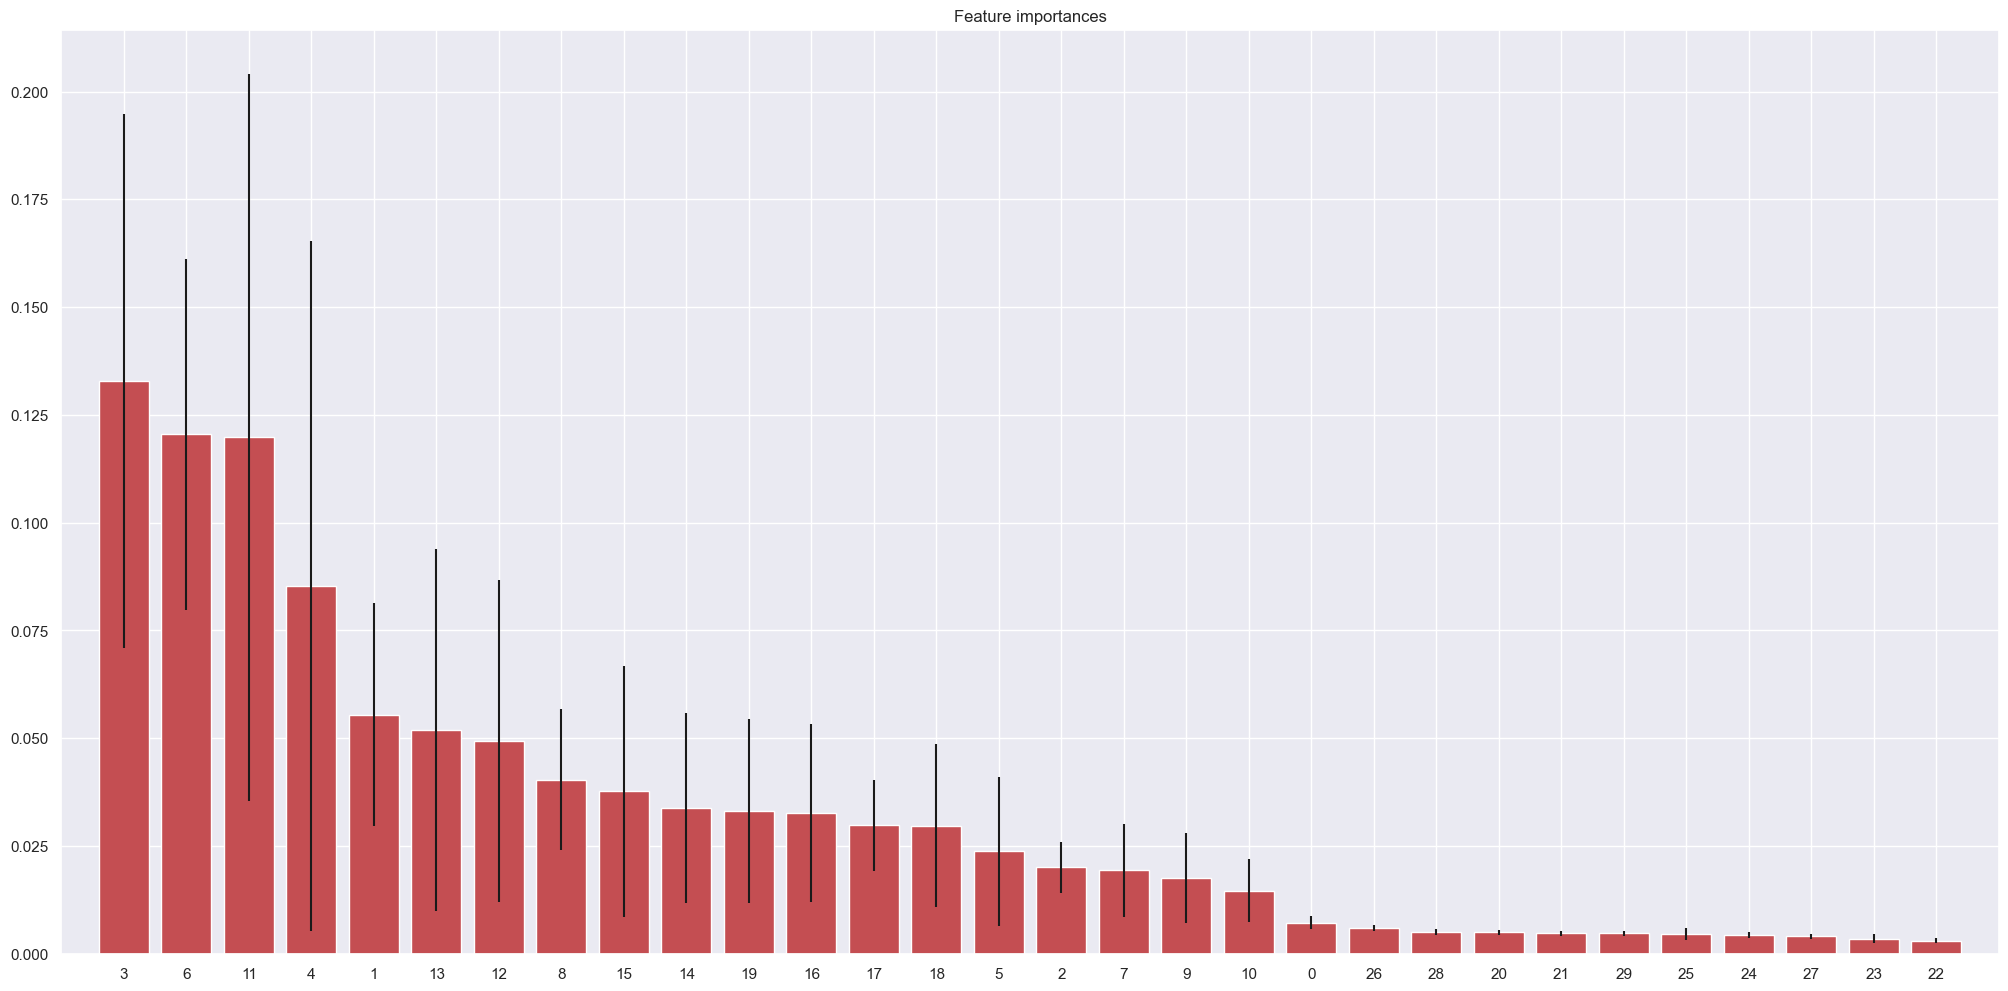

In [125]:
importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

indices = np.argsort(importances)[::-1]

# print the feature ranking

print('Feature ranking')

df = pd.DataFrame()

for i, j in zip(x_train_n, forest.feature_importances_):
    
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

# plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature importances')
plt.bar(range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

#### RandomForestClassifier

In [126]:
# # model definition
# # forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)
# rfc = RandomForestClassifier(n_jobs=-1, random_state=42)
# # XGBClassifier(n_jobs=-1,  random_state=42, max_delta_step=1, eval_metric='binary:logistic')
# # lgbm.LGBMClassifier(n_jobs=-1,  random_state=42)

# # data preparation
# x_train_n = df_train.drop(['satisfaction'], axis=1)
# y_train_n = y_train.values

# # forest.fit(x_train_n, y_train_n)
# rfc.fit(x_train_n, y_train_n)

In [127]:
# y_pred = rfc.predict(x_train_n)

# accuracy = accuracy_score(y_train_n, y_pred)
# print("Accuracy:", accuracy)

# # Export the first three decision trees from the forest

# for i in range(3):
#     tree = rfc.estimators_[i]
#     dot_data = export_graphviz(tree,
#                                feature_names=x_train_n.columns,  
#                                filled=True,  
#                                max_depth=2, 
#                                impurity=False, 
#                                proportion=True)
#     graph = graphviz.Source(dot_data)
#     display(graph)

# Machine Learning

In [128]:
# Feature ranking
#                       feature  importance
# 0            type_of_purchase    0.129738
# 0                instore_wifi    0.120757
# 0               dressing_room    0.119664
# 0                  store_size    0.088519
# 0               customer_type    0.055830
# 0                waiting_room    0.052694
# 0          kids_entertainment    0.048516
# 0     easy_of_online_shopping    0.041841
# 0                    showroom    0.038911
# 0              seller_service    0.033548
# 0                 cleanliness    0.032457
# 0                  self_store    0.032299

In [136]:
cols_selected = ['type_of_purchase', 'instore_wifi', 'dressing_room', 'store_size', 'customer_type', 
                 'waiting_room', 'kids_entertainment','easy_of_online_shopping', 'showroom', 'seller_service', 'cleanliness', 'self_store' ]

x_train = df_train[cols_selected]

df_val = pd.concat([x_validation, y_validation], axis=1)
x_val = df_val[cols_selected]
y_val = y_validation.values

In [137]:
x_val.head(2)

,type_of_purchase,instore_wifi,dressing_room,store_size,customer_type,waiting_room,kids_entertainment,easy_of_online_shopping,showroom,seller_service,cleanliness,self_store
30067,1,1,2,1,0,3,5,0,0,5,2,3
80674,0,2,2,0,0,2,1,4,3,3,2,4


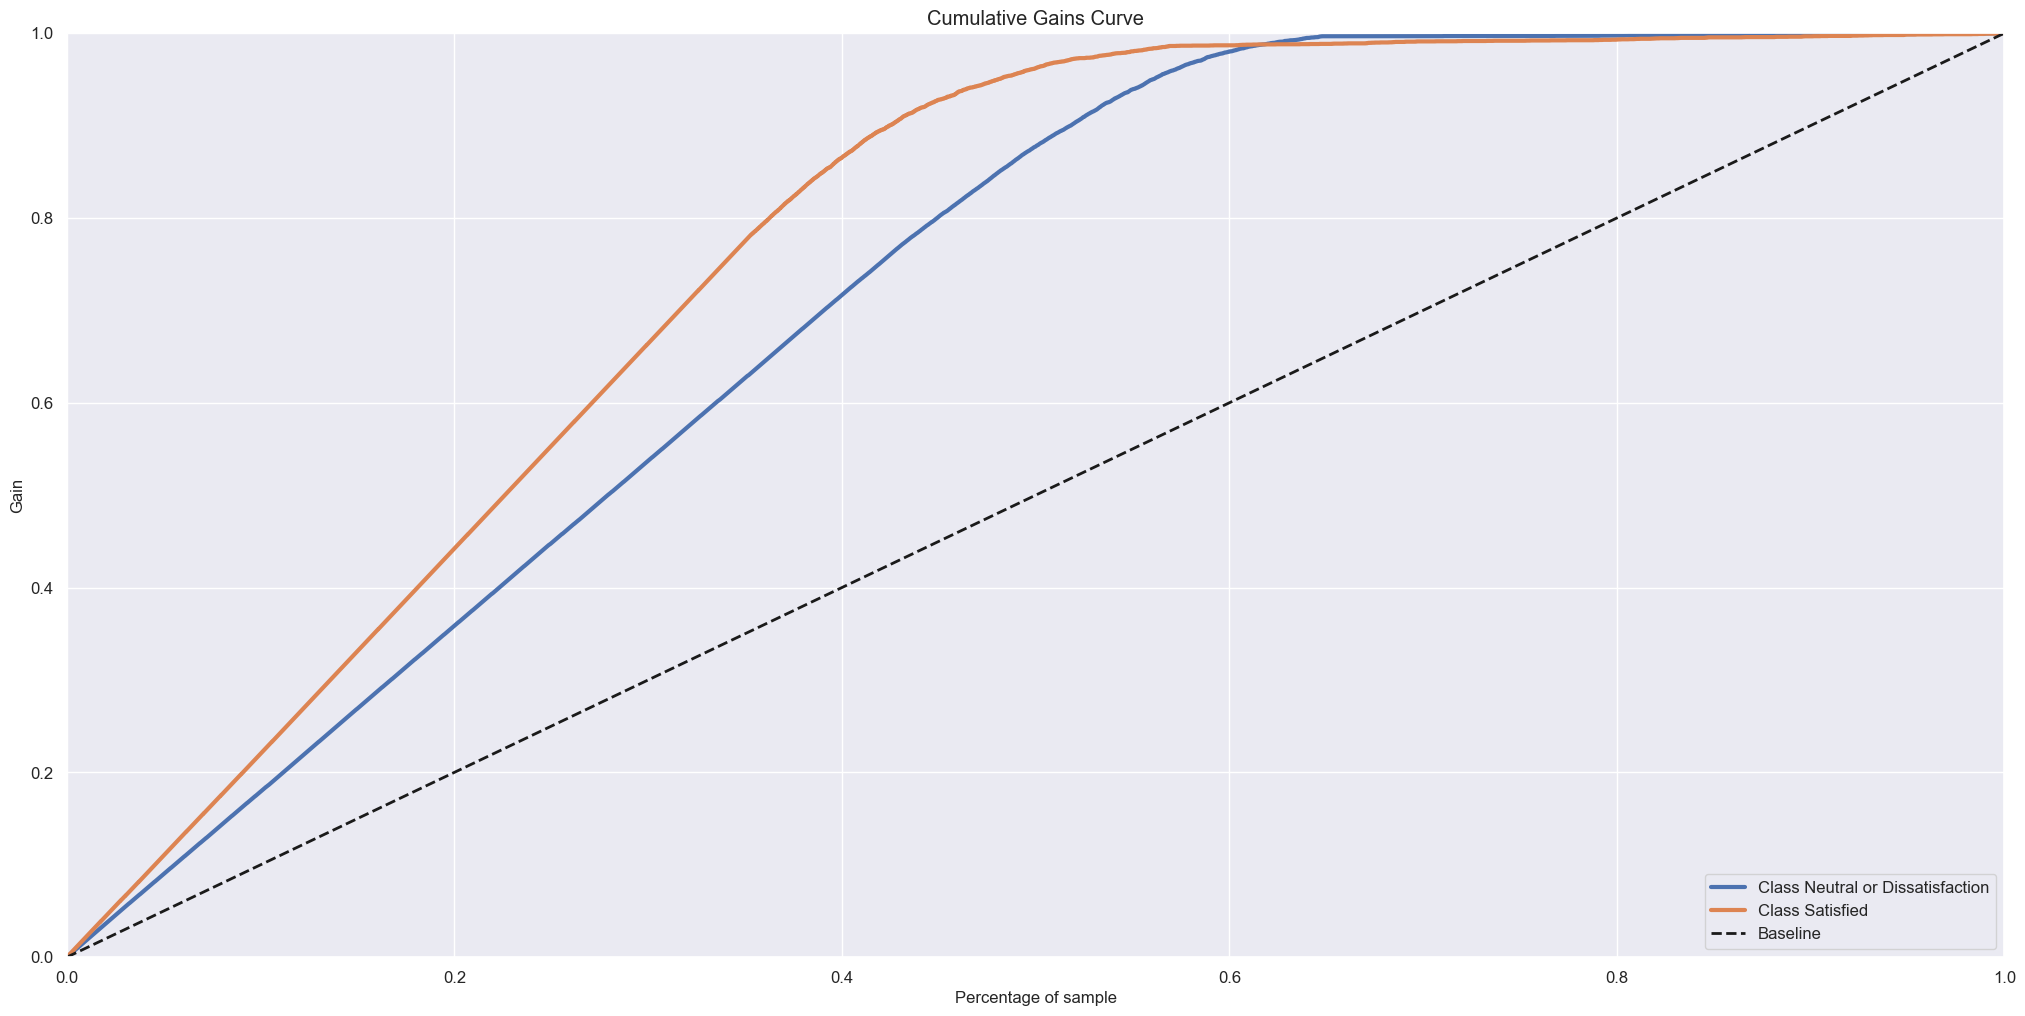

In [138]:
# KNN

# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors = 7)

# model training
knn_model.fit(x_train, y_train)

#model prediction - PODER DE GENERALIZAÇÃO
yhat_knn = knn_model.predict_proba(x_val)

yhat_knn_pred = knn_model.predict(x_val)

# metrica de ordenação 
# accumulative gain

skplt.metrics.plot_cumulative_gain(y_val, yhat_knn);

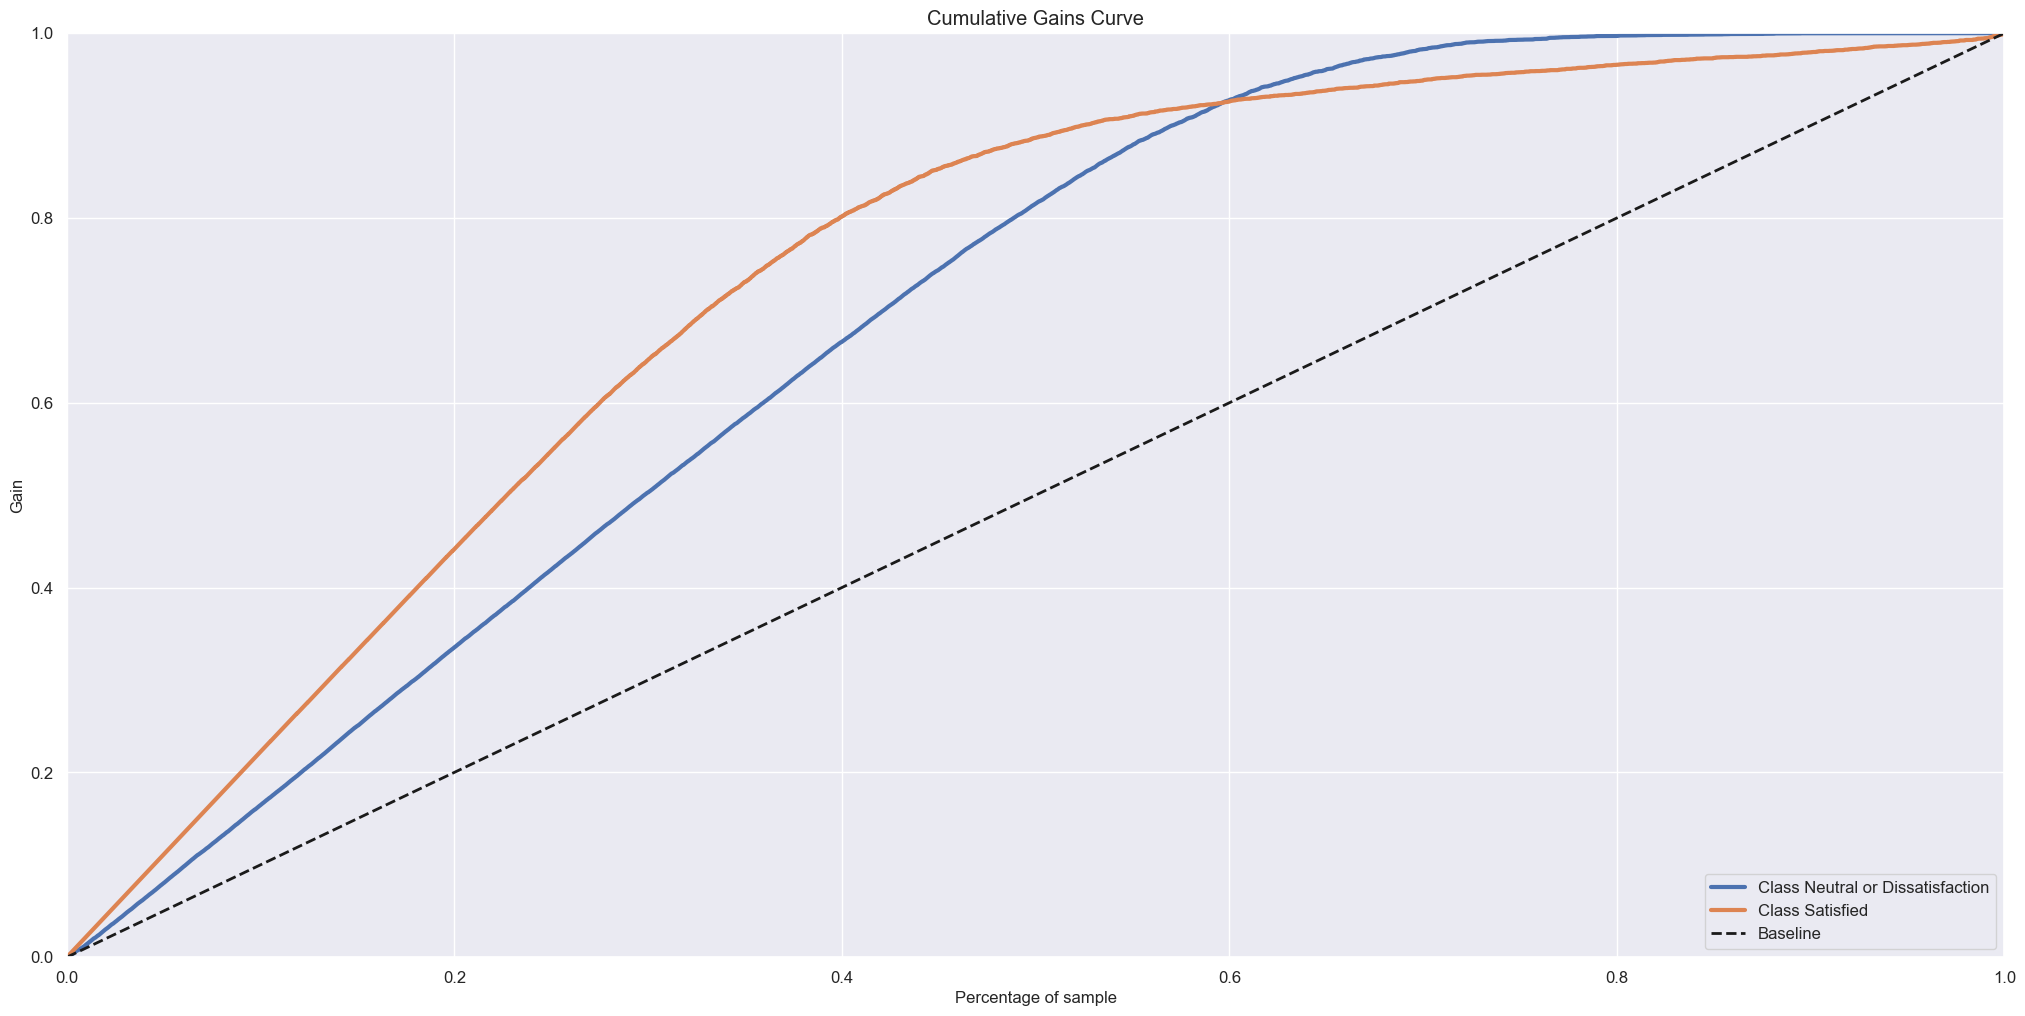

In [141]:
# Logistic Regression

# model definition
lr_model = lm.LogisticRegression( random_state = 42)

# model training 
lr_model.fit(x_train, y_train)

# model prediction
yhat_lr = lr_model.predict_proba(x_val)

yhat_lr_pred = lr_model.predict(x_val)

# metrica de ordenação 
# accumulative gain


skplt.metrics.plot_cumulative_gain(y_val, yhat_lr);

In [160]:
# Random Forest

# model definition
rf_model = en.RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

# model training
rf_model.fit(x_train, y_train)

# model prediction
yhat_rf = rf_model.predict_proba(x_val)

yhat_rf_pred = rf_model.predict(x_val)


In [ ]:
# accuracy = accuracy_score(yhat_rf, yhat_rf_pred, normalize=False)
# print("Accuracy:", accuracy)

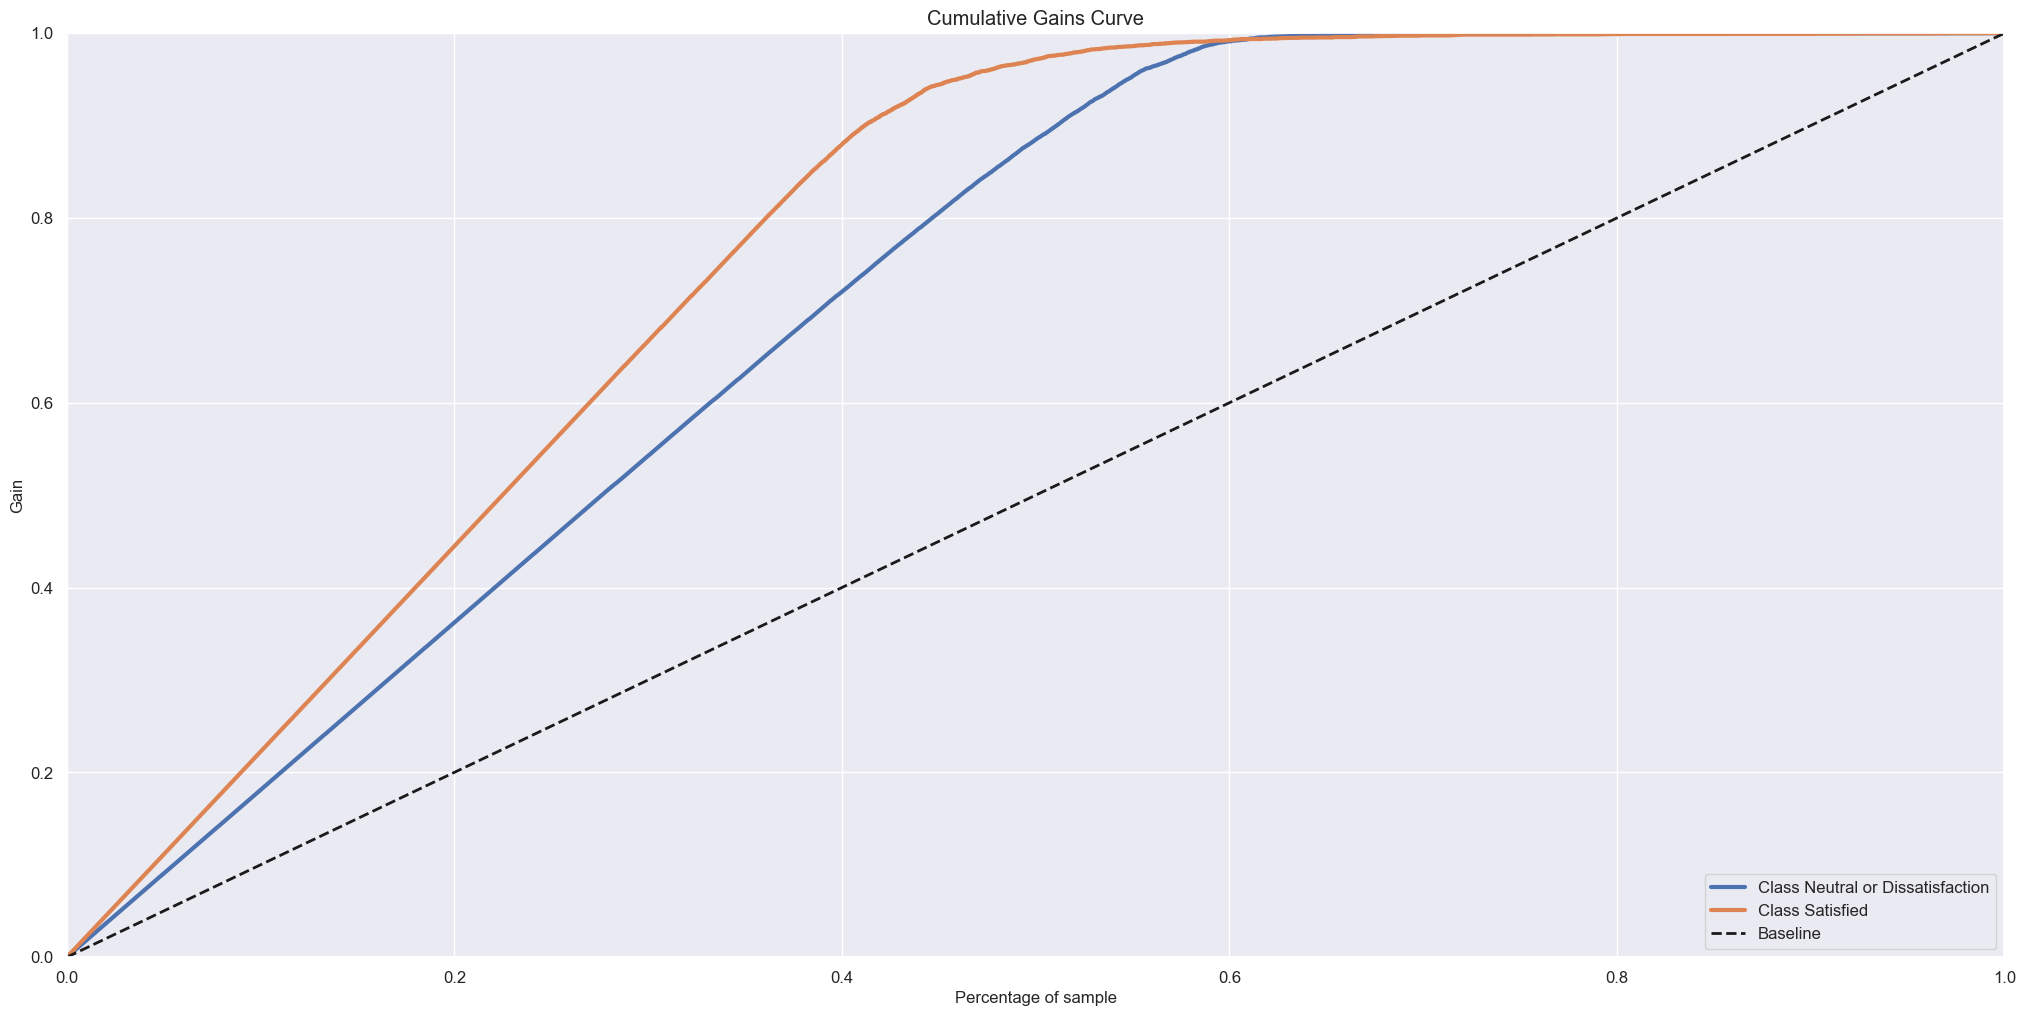

In [149]:
# acumulative gain 
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf);


In [157]:
print("Kappa Score:", yhat_rf_pred)

Kappa Score: ['Neutral or Dissatisfaction' 'Neutral or Dissatisfaction'
 'Neutral or Dissatisfaction' ... 'Neutral or Dissatisfaction'
 'Neutral or Dissatisfaction' 'Satisfied']


In [156]:
# Crie o modelo LGBMClassifier e ajuste-o aos dados de treinamento
model_lgbm = lgbm.LGBMClassifier(n_jobs=-1, random_state=42, class_weight='balanced', n_estimators=500)
model_lgbm.fit(x_train, y_train)

# Faça as previsões usando o conjunto de validação
y_predicted_proba_lgbm = model_lgbm.predict_proba(x_val)
y_predicted_lgbm = model_lgbm.predict(x_val)

# Calculando o Kappa Score
kappa_score_lgbm = cohen_kappa_score(y_val, y_predicted_lgbm)

# Imprimir o Kappa Score e o Relatório de Classificação
print("Kappa Score:", kappa_score_lgbm)
print(classification_report(y_val, y_predicted_lgbm))

Kappa Score: 0.9126299699960372
                            precision    recall  f1-score   support

Neutral or Dissatisfaction       0.96      0.96      0.96      8670
                 Satisfied       0.96      0.95      0.95      7072

                  accuracy                           0.96     15742
                 macro avg       0.96      0.96      0.96     15742
              weighted avg       0.96      0.96      0.96     15742



## Hyperparameter tunning

In [ ]:
parameters = {
    'n_estimators': [500, 1000, 2000, 1500, 2500, 3000],
    'learning_rate': [.1,.3,.5,.8],
    'num_leaves': [2,3,4,5,6,7],
    'max_delta_step': [0,3,8,10],
    'subsample': [.5,1],
    'colsample_bytree': [.2,.5,.8,1]
}
skf = StratifiedKFold(n_splits=5)
rf_search =  BayesSearchCV(estimator=XGBClassifier(n_jobs=-1,objective='multi:softprob'), search_spaces=parameters, 
                            cv=skf, scoring=ndcg_scorer, random_state=42)
rf_search_result = rf_search.fit(x_train,y_train)
rf_search_result.best_params_

In [ ]:
final_model  = XGBClassifier(n_jobs=-1,  random_state=42, max_delta_step=8, colsample_bytree=1, eta=0.1,
                             gamma=5, n_estimators=1000, subsample=1, objective='multi:softprob').fit(X_train,y_train)
y_predicted_proba_xgb = final_model.predict_proba(X_val)
y_predicted_xgb = final_model.predict(X_val)

y_test_matrix = np.zeros(shape=(X_val.shape[0], y_val.unique().shape[0] ) )
y_test_matrix[np.arange(X_val.shape[0]), np.array(y_val)] = 1
                
y_predicted_matrix = np.zeros(shape=(X_val.shape[0], y_val.unique().shape[0]) )
y_predicted_matrix[np.arange(X_val.shape[0]),y_predicted_xgb] = 1

ndcg_score_xgb = ndgc(y_true=y_test_matrix,y_score=y_predicted_matrix, k=5) 
kappa_score_xgb = cohen_kappa_score(y_val, y_predicted_xgb)
print(ndcg_score_xgb)
print(kappa_score_xgb)
print(classification_report(y_val,y_predicted_xgb))

In [ ]:
final_model_result = pd.DataFrame({'model_name':'XGBoost','ndcg_score':ndcg_score_xgb ,'kappa_score':kappa_score_xgb}, index=[0])

In [ ]:
dfi.export(final_model_result, 'final_model_tunned.png')

# Lixo

In [ ]:
le = LabelEncoder()
mms = MinMaxScaler()
rs = RobustScaler()

y_train = pd.Series(le.fit_transform(y_train), index=y_train.index)
y_validation = pd.Series(le.transform(y_validation), index=y_validation.index)


column_trans = make_column_transformer(
    (MinMaxScaler(), ['age']),
    (RobustScaler(), ['carrier_delay_in_minutes', 'delivery_delay_in_minutes', 'sum_delay_in_minute', 'sub_delay_in_minute',
                      'delivery_delay_in_hour', 'carrier_delay_in_hour']),
    (OneHotEncoder(), ['gender', 'customer_type', 'type_of_purchase', 'store_size', 'carrier_delay', 'delivery_delay']),
    (LabelEncoder(), ['carrier_delay_in_min', 'delivery_delay_in_min']),
    remainder='passthrough'
)

# ------------------------

X_train_transformed = pd.DataFrame(column_trans.fit_transform(X_train),
                                   columns=column_trans.get_feature_names_out())

X_test_transformed = pd.DataFrame(column_trans.transform(X_validation),
                                  columns=column_trans.get_feature_names_out())


classifiers = [RandomForestClassifier(n_jobs=-1, random_state=42),
               XGBClassifier(n_jobs=-1,  random_state=42, max_delta_step=1, eval_metric='binary:logistic'),
               lgbm.LGBMClassifier(n_jobs=-1,  random_state=42)]

for classifier in classifiers:
    pipeline_1 = Pipeline(steps= [
        ('preprocessor',column_trans),
        ('feature_selection', SelectFromModel(estimator=classifier) )
        ] )
    pipeline_2 = Pipeline(steps= [
        ('preprocessor',column_trans),
        ('feature_selection', RFE(estimator=classifier) )
        ] )

    permutation_score = permutation_importance(classifier.fit(X_train_transformed, y_train), X_test_transformed, y_validation,
                                                random_state=42, scoring='‘precision', n_repeats=10)

    importance = pd.DataFrame({'features':column_trans.get_feature_names_out(),
                               '‘precision':permutation_score['importances_mean'] } ).sort_values(by='‘precision', ascending=False)

    print('model: {} \n features selected based on feature importance:{} \n\n'.format(pipeline_1['feature_selection'].estimator,
                                                                                      pipeline_1.fit(X_train,y_train).get_feature_names_out(input_features=None) ) )
    print('model: {} \n features_selected based on RFE:{} \n\n'.format(pipeline_2['feature_selection'].estimator,
                                                                       pipeline_2.fit(X_train,y_train).get_feature_names_out(input_features=None) ) )
    print(importance, '\n\n\n')

## Feature Selection

In [ ]:
#Cols selected
cols_selected = ['']      

X_train = X_train_transformed[cols_selected]
X_val = X_test_transformed[cols_selected]

## Machine Learning

In [ ]:
#Making weights for imbalanced set
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
sample_weights = class_weight.compute_sample_weight('balanced', y=y_train )

### RandomForest Classifier

In [ ]:
model_rf = RandomForestClassifier(n_jobs=-1, random_state=42, class_weight='balanced_subsample', n_estimators=500).fit(X_train,y_train)
y_predicted_proba_rf = model_rf.predict_proba(X_val)
y_predicted_rf = model_rf.predict(X_val)

#Make matrix with ground truth and predicted probabilities
y_test_matrix = np.zeros(shape=(X_val.shape[0], y_val.unique().shape[0] ) )
y_test_matrix[np.arange(X_val.shape[0]), np.array(y_val)] = 1
                
#Make matrix with ground truth and predicted probabilities
y_predicted_matrix =  np.zeros(shape=(X_val.shape[0], y_val.unique().shape[0]) )
y_predicted_matrix[np.arange(X_val.shape[0]),y_predicted_rf ] = 1

ndcg_score_rf = ndgc(y_test_matrix,y_predicted_matrix, k=5)
kappa_score_rf = cohen_kappa_score(y_val, y_predicted_rf)
print(ndcg_score_rf)
print(kappa_score_rf)
print(classification_report(y_val,y_predicted_rf))


In [ ]:
skf = StratifiedKFold(n_splits=5)
rf_cv_ndcg= []
rf_cv_kappa = []
for train_ix, test_ix in skf.split(X_train, y_train):
    X_train_cv, X_validation_cv = X_train.iloc[train_ix], X_train.iloc[test_ix]
    y_train_cv, y_validation_cv = y_train.iloc[train_ix], y_train.iloc[test_ix]
    rf_cv = RandomForestClassifier(random_state=42,n_jobs=-1, n_estimators=300, class_weight='balanced_subsample').fit(X_train_cv, y_train_cv)
    y_predicted_rf_cv = rf_cv.predict(X_validation_cv)
    
    #Make matrix with ground truth and predicted probabilities
    y_test_matrix = np.zeros(shape=(X_validation_cv.shape[0], y_validation_cv.unique().shape[0] ) )
    y_test_matrix[np.arange(X_validation_cv.shape[0]), np.array(y_validation_cv)] = 1

    #Make matrix with ground truth and predicted probabilities
    y_predicted_matrix =  np.zeros(shape=(X_validation_cv.shape[0], y_validation_cv.unique().shape[0]) )
    y_predicted_matrix[np.arange(X_validation_cv.shape[0]),y_predicted_rf_cv ] = 1

    
    ndcg_score_rf = ndgc(y_true=y_test_matrix,y_score=y_predicted_matrix, k=5)
    kappa_rf = cohen_kappa_score(y_validation_cv, y_predicted_rf_cv)
    rf_cv_ndcg.append(ndcg_score_rf)
    rf_cv_kappa.append(kappa_rf)

rf_cv_ndcg_mean = np.mean(rf_cv_ndcg)
rf_cv_ndcg_std = np.std(rf_cv_ndcg)
rf_cv_kappa_mean = np.mean(rf_cv_kappa)
rf_cv_kappa_std = np.std(rf_cv_kappa)

rf_cv_result = pd.DataFrame({'model_name':'random_forest','ndcg_score':ndcg_score_rf ,'kappa_score':kappa_score_rf,'ndcg_score_cv': rf_cv_ndcg_mean,
                      'std_ndcg_cv':rf_cv_ndcg_std,'kappa_score_cv': rf_cv_kappa_mean,'std_kappa_cv':rf_cv_kappa_std}, index=[0])
display(rf_cv_result)

### XGBoost Classifier 

In [ ]:

model_xgb = XGBClassifier(n_jobs=-1,  random_state=42, max_delta_step=4, eval_metric='ndcg', objective='multi:softprob').fit(X_train,y_train)
y_predicted_proba_xgb = model_xgb.predict_proba(X_val)
y_predicted_xgb = model_xgb.predict(X_val)

y_test_matrix = np.zeros(shape=(X_val.shape[0], y_val.unique().shape[0] ) )
y_test_matrix[np.arange(X_val.shape[0]), np.array(y_val)] = 1
                
y_predicted_matrix = np.zeros(shape=(X_val.shape[0], y_val.unique().shape[0]) )
y_predicted_matrix[np.arange(X_val.shape[0]),y_predicted_xgb] = 1

ndcg_score_xgb = ndgc(y_true=y_test_matrix,y_score=y_predicted_matrix, k=5) 
kappa_score_xgb = cohen_kappa_score(y_val, y_predicted_xgb)
print(ndcg_score_xgb)
print(kappa_score_xgb)
print(classification_report(y_val,y_predicted_xgb))

In [ ]:
skf = StratifiedKFold(n_splits=5)
xgb_cv_ndcg= []
xgb_cv_kappa = []
for train_ix, test_ix in skf.split(X_train, y_train):
    X_train_cv, X_validation_cv = X_train.iloc[train_ix], X_train.iloc[test_ix]
    y_train_cv, y_validation_cv = y_train.iloc[train_ix], y_train.iloc[test_ix]
    xgb_cv = XGBClassifier(n_jobs=-1,  random_state=42, max_delta_step=2, eval_metric='ndcg', objective='multi:softprob').fit(X_train_cv,y_train_cv)
    y_predicted_xgb_cv = xgb_cv.predict(X_validation_cv)
    
    #Make matrix with ground truth and predicted probabilities
    y_test_matrix = np.zeros(shape=(X_validation_cv.shape[0], y_validation_cv.unique().shape[0] ) )
    y_test_matrix[np.arange(X_validation_cv.shape[0]), np.array(y_validation_cv)] = 1

    #Make matrix with ground truth and predicted probabilities
    y_predicted_matrix =  np.zeros(shape=(X_validation_cv.shape[0], y_validation_cv.unique().shape[0]) )
    y_predicted_matrix[np.arange(X_validation_cv.shape[0]),y_predicted_xgb_cv ] = 1

    
    ndcg_score_xgb = ndgc(y_true=y_test_matrix,y_score=y_predicted_matrix, k=5)
    kappa_xgb = cohen_kappa_score(y_validation_cv, y_predicted_xgb_cv)
    xgb_cv_ndcg.append(ndcg_score_xgb)
    xgb_cv_kappa.append(kappa_xgb)

xgb_cv_ndcg_mean = np.mean(xgb_cv_ndcg)
xgb_cv_ndcg_std = np.std(xgb_cv_ndcg)
xgb_cv_kappa_mean = np.mean(xgb_cv_kappa)
xgb_cv_kappa_std = np.std(xgb_cv_kappa)

xgb_cv_result = pd.DataFrame({'model_name':'XGBoost','ndcg_score':ndcg_score_xgb ,'kappa_score':kappa_score_xgb,'ndcg_score_cv': xgb_cv_ndcg_mean,
                      'std_ndcg_cv':xgb_cv_ndcg_std,'kappa_score_cv': xgb_cv_kappa_mean,'std_kappa_cv':xgb_cv_kappa_std}, index=[0]) 


### LGBM Classifier

In [ ]:
model_lgbm = lgbm.LGBMClassifier(n_jobs=-1,  random_state=42, class_weight='balanced', n_estimators=500, objective='multiclass').fit(X_train,y_train)
y_predicted_proba_lgbm = model_lgbm.predict_proba(X_val)
y_predicted_lgbm = model_lgbm.predict(X_val)

y_test_matrix = np.zeros(shape=(X_val.shape[0], y_val.unique().shape[0] ) )
y_test_matrix[np.arange(X_val.shape[0]), np.array(y_val)] = 1
                
y_predicted_matrix = np.zeros(shape=(X_val.shape[0], y_val.unique().shape[0]) )
y_predicted_matrix[np.arange(X_val.shape[0]),y_predicted_lgbm] = 1

ndcg_score_lgbm = ndgc(y_true=y_test_matrix,y_score=y_predicted_matrix, k=5) 
kappa_score_lgbm = cohen_kappa_score(y_val, y_predicted_lgbm)
print(ndcg_score_lgbm)
print(kappa_score_lgbm)
print(classification_report(y_val,y_predicted_lgbm))

In [ ]:
skf = StratifiedKFold(n_splits=5)
lgbm_cv_ndcg= []
lgbm_cv_kappa = []
for train_ix, test_ix in skf.split(X_train, y_train):
    X_train_cv, X_validation_cv = X_train.iloc[train_ix], X_train.iloc[test_ix]
    y_train_cv, y_validation_cv = y_train.iloc[train_ix], y_train.iloc[test_ix]
    lgbm_cv = lgbm.LGBMClassifier(n_jobs=-1,  random_state=42, class_weight='balanced', n_estimators=500, 
                                              objective='multiclass').fit(X_train_cv,y_train_cv)
    y_predicted_lgbm_cv = lgbm_cv.predict(X_validation_cv)
    
    #Make matrix with ground truth and predicted probabilities
    y_test_matrix = np.zeros(shape=(X_validation_cv.shape[0], y_validation_cv.unique().shape[0] ) )
    y_test_matrix[np.arange(X_validation_cv.shape[0]), np.array(y_validation_cv)] = 1

    #Make matrix with ground truth and predicted probabilities
    y_predicted_matrix =  np.zeros(shape=(X_validation_cv.shape[0], y_validation_cv.unique().shape[0]) )
    y_predicted_matrix[np.arange(X_validation_cv.shape[0]),y_predicted_lgbm_cv ] = 1

    
    ndcg_score_lgbm = ndgc(y_true=y_test_matrix,y_score=y_predicted_matrix, k=5)
    kappa_lgbm = cohen_kappa_score(y_validation_cv, y_predicted_lgbm_cv)
    lgbm_cv_ndcg.append(ndcg_score_lgbm)
    lgbm_cv_kappa.append(kappa_lgbm)

lgbm_cv_ndcg_mean = np.mean(lgbm_cv_ndcg)
lgbm_cv_ndcg_std = np.std(lgbm_cv_ndcg)
lgbm_cv_kappa_mean = np.mean(lgbm_cv_kappa)
lgbm_cv_kappa_std = np.std(lgbm_cv_kappa)

lgbm_cv_result = pd.DataFrame({'model_name':'LGBM','ndcg_score':ndcg_score_lgbm ,'kappa_score':kappa_score_lgbm,'ndcg_score_cv': lgbm_cv_ndcg_mean,
                      'std_ndcg_cv':lgbm_cv_ndcg_std,'kappa_score_cv': lgbm_cv_kappa_mean,'std_kappa_cv':lgbm_cv_kappa_std}, index=[0])
display(lgbm_cv_result)

### KNeighbors Classifier

In [ ]:
model_knn = KNeighborsClassifier(n_jobs=-1, n_neighbors=15).fit(X_train,y_train)
y_predicted_proba_knn = model_knn.predict_proba(X_val)
y_predicted_knn = model_knn.predict(X_val)

y_test_matrix = np.zeros(shape=(X_val.shape[0], y_val.unique().shape[0] ) )
y_test_matrix[np.arange(X_val.shape[0]), np.array(y_val)] = 1
                
y_predicted_matrix = np.zeros(shape=(X_val.shape[0], y_val.unique().shape[0]) )
y_predicted_matrix[np.arange(X_val.shape[0]),y_predicted_knn] = 1

ndcg_score_knn = ndgc(y_true=y_test_matrix,y_score=y_predicted_matrix, k=5) 
kappa_score_knn = cohen_kappa_score(y_val, y_predicted_knn)
print(ndcg_score_knn)
print(kappa_score_knn)
print(classification_report(y_val,y_predicted_knn))

In [ ]:
skf = StratifiedKFold(n_splits=5)
knn_cv_ndcg= []
knn_cv_kappa = []
for train_ix, test_ix in skf.split(X_train, y_train):
    X_train_cv, X_validation_cv = X_train.iloc[train_ix], X_train.iloc[test_ix]
    y_train_cv, y_validation_cv = y_train.iloc[train_ix], y_train.iloc[test_ix]
    knn_cv = KNeighborsClassifier(n_jobs=-1, n_neighbors=15).fit(X_train_cv,y_train_cv)
    y_predicted_knn_cv = knn_cv.predict(X_validation_cv)
    
    #Make matrix with ground truth and predicted probabilities
    y_test_matrix = np.zeros(shape=(X_validation_cv.shape[0], y_validation_cv.unique().shape[0] ) )
    y_test_matrix[np.arange(X_validation_cv.shape[0]), np.array(y_validation_cv)] = 1

    #Make matrix with ground truth and predicted probabilities
    y_predicted_matrix =  np.zeros(shape=(X_validation_cv.shape[0], y_validation_cv.unique().shape[0]) )
    y_predicted_matrix[np.arange(X_validation_cv.shape[0]),y_predicted_knn_cv ] = 1

    
    ndcg_score_knn = ndgc(y_true=y_test_matrix,y_score=y_predicted_matrix, k=5)
    kappa_knn_cv = cohen_kappa_score(y_validation_cv, y_predicted_knn_cv)
    knn_cv_ndcg.append(ndcg_score_knn)
    knn_cv_kappa.append(kappa_knn_cv)

knn_cv_ndcg_mean = np.mean(knn_cv_ndcg)
knn_cv_ndcg_std = np.std(knn_cv_ndcg)
knn_cv_kappa_mean = np.mean(knn_cv_kappa)
knn_cv_kappa_std = np.std(knn_cv_kappa)

knn_cv_result = pd.DataFrame({'model_name':'KNN','ndcg_score':ndcg_score_knn ,'kappa_score':kappa_score_knn,'ndcg_score_cv': knn_cv_ndcg_mean,
                      'std_ndcg_cv':knn_cv_ndcg_std,'kappa_score_cv': knn_cv_kappa_mean,'std_kappa_cv':knn_cv_kappa_std}, index=[0])

display(knn_cv_result)

In [ ]:
final_result = pd.concat([rf_cv_result, xgb_cv_result,lgbm_cv_result,knn_cv_result], axis=0).sort_values(by='ndcg_score', ascending=False)
display(final_result)

## Hyperparameter tunning

In [ ]:
parameters = {
    'n_estimators': [1000,1500,2500],
    'eta': [.1,.3,.5,.8],
    'gamma': [0,5,10,20],
    'max_delta_step': [0,3,8,10],
    'subsample': [.5,1],
    'colsample_bytree': [.2,.5,.8,1]
}
skf = StratifiedKFold(n_splits=5)
rf_search =  BayesSearchCV(estimator=XGBClassifier(n_jobs=-1,objective='multi:softprob'), search_spaces=parameters, 
                            cv=skf, scoring=ndcg_scorer, random_state=42)
rf_search_result = rf_search.fit(X_train,y_train)
rf_search_result.best_params_

In [ ]:
final_model  = XGBClassifier(n_jobs=-1,  random_state=42, max_delta_step=8, colsample_bytree=1, eta=0.1,
                             gamma=5, n_estimators=1000, subsample=1, objective='multi:softprob').fit(X_train,y_train)
y_predicted_proba_xgb = final_model.predict_proba(X_val)
y_predicted_xgb = final_model.predict(X_val)

y_test_matrix = np.zeros(shape=(X_val.shape[0], y_val.unique().shape[0] ) )
y_test_matrix[np.arange(X_val.shape[0]), np.array(y_val)] = 1
                
y_predicted_matrix = np.zeros(shape=(X_val.shape[0], y_val.unique().shape[0]) )
y_predicted_matrix[np.arange(X_val.shape[0]),y_predicted_xgb] = 1

ndcg_score_xgb = ndgc(y_true=y_test_matrix,y_score=y_predicted_matrix, k=5) 
kappa_score_xgb = cohen_kappa_score(y_val, y_predicted_xgb)
print(ndcg_score_xgb)
print(kappa_score_xgb)
print(classification_report(y_val,y_predicted_xgb))

In [ ]:
final_model_result = pd.DataFrame({'model_name':'XGBoost','ndcg_score':ndcg_score_xgb ,'kappa_score':kappa_score_xgb}, index=[0])

In [ ]:
dfi.export(final_model_result, 'final_model_tunned.png')